![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Bartosz Bogucki |
<b>Student-nr</b>: r1032166 |
<b>Date</b>: May 18, 2025
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are:
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication.
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes.

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties.

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

# the following packages are imported when needed throughout this notebook,
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

from google.colab import files
uploaded = files.upload()
import zipfile
import os
with zipfile.ZipFile("CalTechFacesDirs.zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("localmodules.zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("models.zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("notebook_images.zip", 'r') as zip_ref:
    zip_ref.extractall()

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score, f1_score, confusion_matrix, matthews_corrcoef, fbeta_score
from tqdm import tqdm
from scipy.spatial.distance import euclidean
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from localmodules.local_binary_patterns import LBP
#from scipy.stats import chisquare
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

Saving CalTechFacesDirs.zip to CalTechFacesDirs.zip
Saving localmodules.zip to localmodules.zip
Saving models.zip to models.zip
Saving notebook_images.zip to notebook_images.zip


## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module.
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

* [The CALTECH Faces dataset](https://data.caltech.edu/records/6rjah-hdv18) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data.

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn.


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm
* target: N-dimensional vector of labels

In [2]:
# size of each face after preprocessing
face_size=(47, 47)

In [3]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1


    return gray, imagePath.parent.name

# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully
# Please note that 5 images were removed from the original set, because
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [4]:
# display data structure
display(data)

{'images': [array([[ 87,  85,  95, ...,  93,  85,  86],
         [100, 100,  97, ...,  89,  88,  88],
         [ 95,  95,  97, ...,  86,  91,  90],
         ...,
         [ 62,  62,  68, ...,  88,  89,  68],
         [ 61,  59,  63, ...,  81,  85,  61],
         [ 56,  61,  62, ...,  83,  92,  69]], dtype=uint8),
  array([[169, 183, 188, ..., 134, 126, 135],
         [ 89,  91,  94, ..., 141, 134, 134],
         [ 88,  87,  82, ..., 137, 139, 135],
         ...,
         [147, 146, 141, ..., 146, 146, 163],
         [102, 108, 133, ..., 153, 146, 161],
         [ 94,  91,  87, ..., 147, 143, 154]], dtype=uint8),
  array([[ 64,  60,  64, ...,  79,  80,  88],
         [ 60,  60,  66, ..., 101,  99,  99],
         [ 65,  65,  66, ...,  89,  92, 102],
         ...,
         [ 62,  56,  61, ...,  64,  69, 120],
         [ 58,  59,  59, ...,  71,  61,  88],
         [ 48,  56,  55, ...,  69,  72,  98]], dtype=uint8),
  array([[138, 135, 138, ...,  61,  57,  32],
         [140, 136, 139, ...,

### 2. Inspect some images

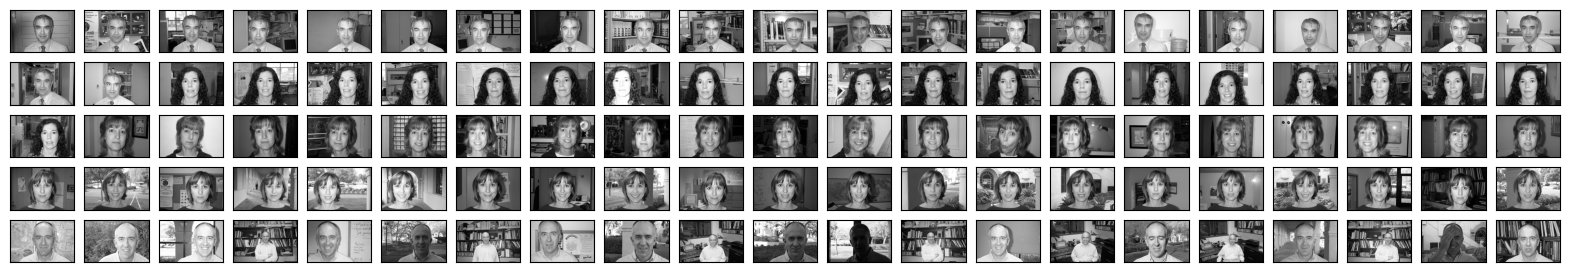

In [5]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes.

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1).

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [6]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [7]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()

        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()

        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data),
              images     = np.array(images),
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [8]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

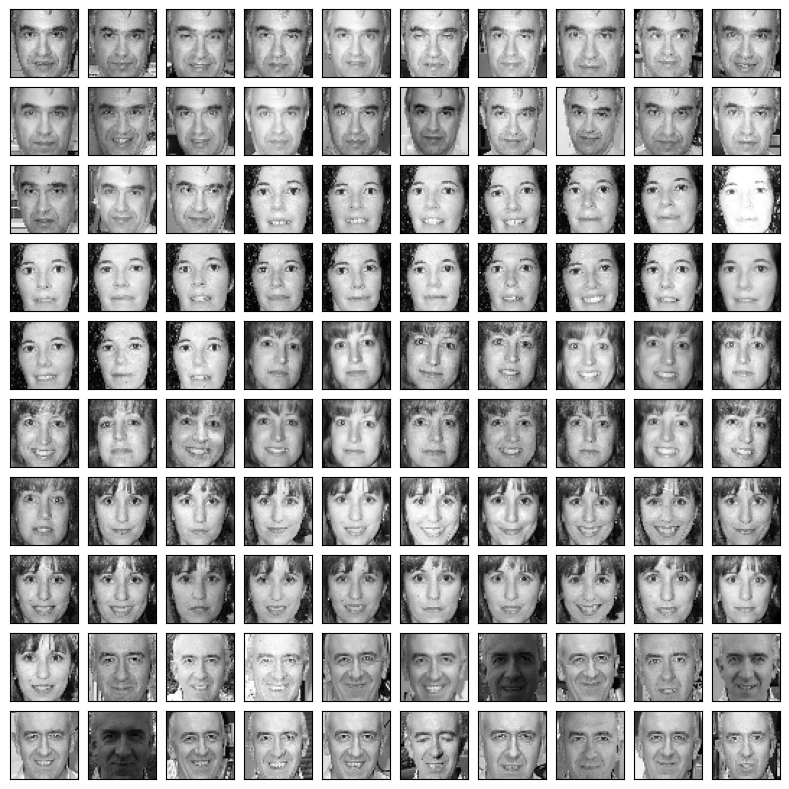

In [9]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping.

In [11]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True,
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion?

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition.

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [ ]:
# if DESC == FeatureDescriptor.PCA:
#     # Compute a PCA (eigenfaces) on the face dataset
#     num_components = min(num_components, min(n_samples, n_features))
#     print("num_components {n}".format(n=num_components))
#     desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
#     X_pca = desc.transform(faces.data)
#     embedded = X_pca

### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from scipy.spatial.distance import euclidean

# if DESC == FeatureDescriptor.LDA:
#     num_components = min(num_components, min(n_classes - 1, n_features))
#     desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
#     X_lda = desc.fit_transform(faces.data, faces.target)
#     embedded = X_lda

#     dist_metric = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [ ]:
# from localmodules.local_binary_patterns import LBP
# from scipy.stats import chisquare

# if DESC == FeatureDescriptor.LBP:
#     desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
#     embedded = desc.describe_list(faces.images[...,0])

#     dist_metric = chisquare

# # Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

# def CHI2(histA, histB, eps=1e-10):
#     # compute the chi-squared distance
#     d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

#     # return the chi-squared distance
#     return d

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms.
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics.

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification.
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations.
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br>

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function.
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large.







There is a very elegant Python implementation available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface.

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough.

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [ ]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese

#some older versions may need this
# import tensorflow as tf
# tf.enable_eager_execution()


encoder, model = siamese.create_siamese_model(imshape, num_components)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_193"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 47, 47, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_35      │ (None, 47, 47, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 35)        │    299,107 │ input_layer_34[0… │
│ (Sequential)        │                   │            │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 1)         │          0 │ sequential_11[0]… │
│                     │                   │            │ sequential_11[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 299,107 (1.14 MB)

 Trainable params: 299,107 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

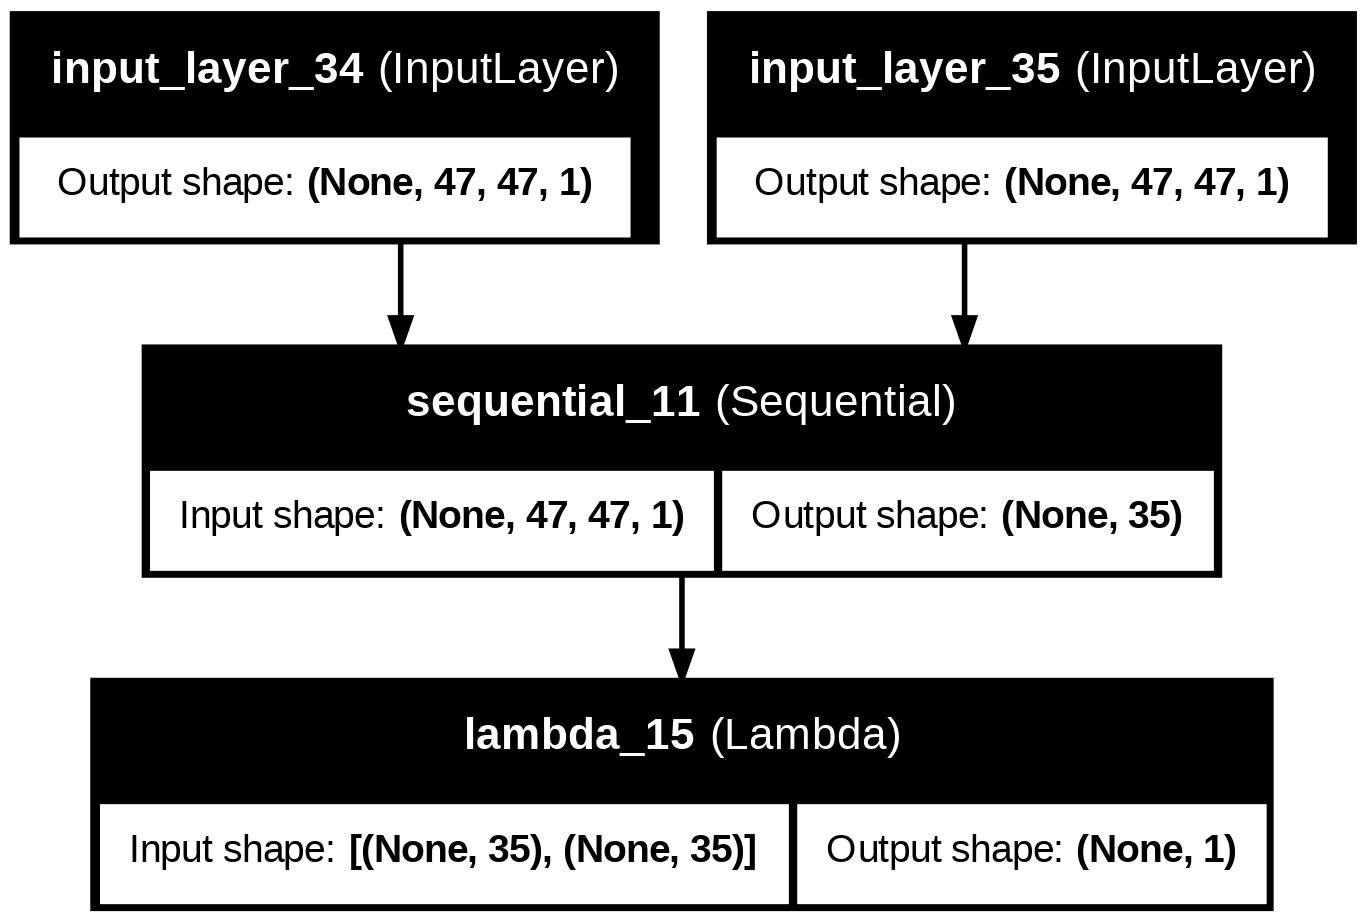

In [ ]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [ ]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

try:
    encoder_siamese, model_siamese = siamese.create_siamese_model(imshape, num_components)
    model_siamese.load_weights("siamese.weights.h5")
    encoder_siamese = model_siamese.get_layer(index=2)
except:
    if DESC == FeatureDescriptor.DL:
        x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
        rms = Adam()
        model.compile(
            loss=siamese.contrastive_loss,
            optimizer=rms,
            metrics = [siamese.accuracy],
            run_eagerly=True)

        epochs = 10
        history = model.fit([x_train[:, 0], x_train[:, 1]], y_train,
                  validation_split=0.2,
                  batch_size=32, verbose=2, epochs=epochs)

        model.save_weights("siamese.weights.h5")
        encoder_siamese, model_siamese = siamese.create_siamese_model(imshape, num_components)
        model_siamese.load_weights("siamese.weights.h5")
        encoder_siamese = model_siamese.get_layer(index=2)

        test_scores = model_siamese.predict([x_test[:, 0], x_test[:, 1]])
        test_acc = accuracy_score(y_test, test_scores > 0.5)
        print("Accuracy on the test set: {}".format(test_acc))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 - 33s - 877ms/step - accuracy: 0.5005 - loss: 0.0995 - val_accuracy: 0.5193 - val_loss: 0.0532
Epoch 2/10
38/38 - 49s - 1s/step - accuracy: 0.5155 - loss: 0.0433 - val_accuracy: 0.5255 - val_loss: 0.0374
Epoch 3/10
38/38 - 77s - 2s/step - accuracy: 0.5162 - loss: 0.0275 - val_accuracy: 0.5209 - val_loss: 0.0280
Epoch 4/10
38/38 - 35s - 915ms/step - accuracy: 0.5111 - loss: 0.0200 - val_accuracy: 0.5244 - val_loss: 0.0259
Epoch 5/10
38/38 - 37s - 964ms/step - accuracy: 0.5139 - loss: 0.0162 - val_accuracy: 0.5250 - val_loss: 0.0197
Epoch 6/10
38/38 - 40s - 1s/step - accuracy: 0.5175 - loss: 0.0120 - val_accuracy: 0.5258 - val_loss: 0.0174
Epoch 7/10
38/38 - 38s - 994ms/step - accuracy: 0.5203 - loss: 0.0094 - val_accuracy: 0.5268 - val_loss: 0.0153
Epoch 8/10
38/38 - 38s - 1s/step - accuracy: 0.5133 - loss: 0.0070 - val_accuracy: 0.5270 - val_loss: 0.0137
Epoch 9/10
38/38 - 39s - 1s/step - accuracy: 0.5230 - loss: 0.0057 - val_accuracy: 0.5270 - val_loss: 0.0123
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
Accuracy on the test set: 1.0


In [ ]:
system_embeddings = {}
system_metrics = {}

def CHI2(histA, histB, eps=1e-10):
    return 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

for desc_type in [FeatureDescriptor.LBP, FeatureDescriptor.PCA, FeatureDescriptor.LDA, FeatureDescriptor.DL]:
    print(f"Processing: {desc_type.name}")

    if desc_type == FeatureDescriptor.PCA:
        # Compute a PCA (eigenfaces) on the face dataset
        num_components = min(num_components, min(n_samples, n_features))
        print("num_components {n}".format(n=num_components))
        desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
        X_pca = desc.transform(faces.data)
        embedded = X_pca

        dist_metric = euclidean

    elif desc_type == FeatureDescriptor.LDA:
        num_components = min(num_components, min(n_classes - 1, n_features))
        desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
        X_lda = desc.fit_transform(faces.data, faces.target)
        embedded = X_lda

        dist_metric = euclidean

    elif desc_type == FeatureDescriptor.LBP:
        desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
        embedded = desc.describe_list(faces.images[...,0])

        dist_metric = CHI2

    elif desc_type == FeatureDescriptor.DL:
        embedded = encoder_siamese(faces.images.astype(np.float32)).numpy()
        dist_metric = euclidean

    system_embeddings[desc_type.name] = embedded
    system_metrics[desc_type.name] = dist_metric

Processing: LBP
Processing: PCA
num_components 35
Processing: LDA
Processing: DL


## IV. Mandatory tasks

<b>The student should do all of the tasks indicated in this section</b>.
 All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


## 1. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used.

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting


On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score.

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

In [ ]:
# Assume `faces.target` is already defined
labels = faces.target
n_samples = len(labels)

# Storage for similarity scores and ground truth labels
system_scores = {}
system_labels = {}

for system_name, embedded in system_embeddings.items():
    print(f"Processing: {system_name}")
    dist_metric = system_metrics[system_name]

    # Compute distance matrix
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples)):
        for j in range(i, n_samples):
            d = dist_metric(embedded[i], embedded[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d  # Symmetric

    # Normalize distances to similarity scores
    max_dist = np.max(distance_matrix)
    scores, true_labels = [], []

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            is_genuine = int(labels[i] == labels[j])
            similarity = 1 - (distance_matrix[i, j] / max_dist)

            scores.append(similarity)
            true_labels.append(is_genuine)

    # Store results
    system_scores[system_name] = np.array(scores)
    system_labels[system_name] = np.array(true_labels)

Processing: LBP


100%|██████████| 440/440 [00:01<00:00, 327.29it/s]


Processing: PCA


100%|██████████| 440/440 [00:00<00:00, 692.83it/s]


Processing: LDA


100%|██████████| 440/440 [00:00<00:00, 652.29it/s]


Processing: DL


100%|██████████| 440/440 [00:00<00:00, 533.31it/s]


## 2. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1.

### 2.1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

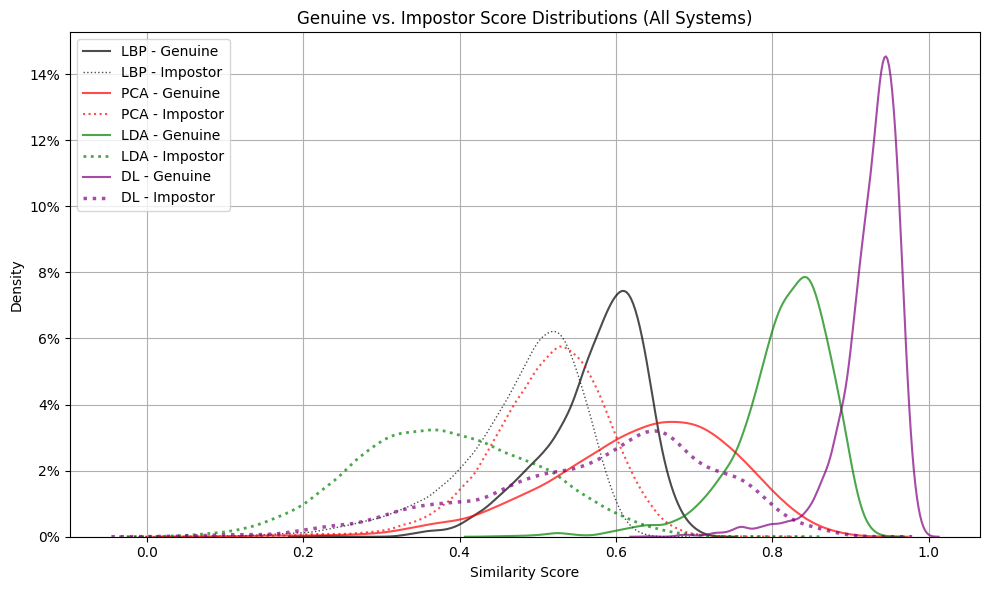

In [ ]:
# Build `systems` dictionary from your stored system results
systems = {
    name: (system_labels[name], system_scores[name])
    for name in system_scores
}

colors = ['black', 'red', 'green', 'purple']  # 1 per system

plt.figure(figsize=(10, 6))

for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
    # Separate genuine and impostor scores
    genuine_scores = scores[genuine_id == 1]
    impostor_scores = scores[genuine_id == 0]

    # Plot KDE curves for each system
    sns.kdeplot(genuine_scores, label=f"{system_name} - Genuine", color=colors[i],
                linestyle='-', alpha=0.7)
    sns.kdeplot(impostor_scores, label=f"{system_name} - Impostor", color=colors[i],
                linestyle=':', alpha=0.7, linewidth=1 + i / 2)

# Format y-axis as percentage
def percent(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent))

# Final touches
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.title("Genuine vs. Impostor Score Distributions (All Systems)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<b>Q3: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

LBP:
  Max F1-score: 0.4558 at threshold 0.5918 with accuracy of 0.9522
  Max Accuracy: 0.9643 at threshold 0.6122 with F1-score of 0.4275

PCA:
  Max F1-score: 0.5219 at threshold 0.6531 with accuracy of 0.9621
  Max Accuracy: 0.9685 at threshold 0.6939 with F1-score of 0.4788

LDA:
  Max F1-score: 0.9581 at threshold 0.7143 with accuracy of 0.9964
  Max Accuracy: 0.9964 at threshold 0.7143 with F1-score of 0.9581

DL:
  Max F1-score: 0.9288 at threshold 0.8776 with accuracy of 0.9939
  Max Accuracy: 0.9939 at threshold 0.8776 with F1-score of 0.9288



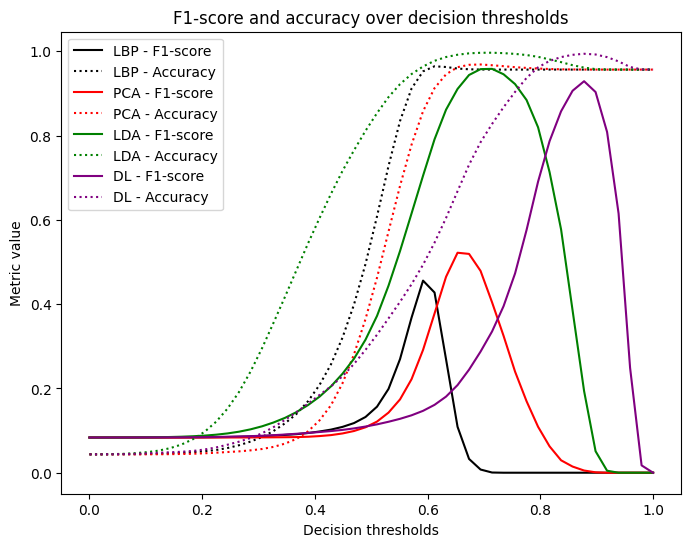

In [ ]:
def evaluate_metrics(genuine_id, scores, thresholds):
    """Compute F1-score and accuracy for different threshold values."""
    f1_scores = []
    accuracies = []

    for threshold in thresholds:
        predictions = (scores >= threshold).astype(int)
        f1_scores.append(f1_score(genuine_id, predictions))
        accuracies.append(accuracy_score(genuine_id, predictions))

    return np.array(f1_scores), np.array(accuracies)

def plot_f1_accuracy(systems, thresholds):
    """Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        f1_scores, accuracies = evaluate_metrics(genuine_id, scores, thresholds)

        plt.plot(thresholds, f1_scores, linestyle='-', label=f"{system_name} - F1-score", color=colors[i])
        plt.plot(thresholds, accuracies, linestyle=':', label=f"{system_name} - Accuracy", color=colors[i])

        """Calculate the threshold and accuracy for which F1 is maximal."""
        max_f1_index = np.argmax(f1_scores)
        max_f1_value = f1_scores[max_f1_index]
        max_f1_threshold = thresholds[max_f1_index]
        max_f1_accuracy = accuracies[max_f1_index]

        """Calculate the threshold and F1 for which accuracy is maximal."""
        max_acc_index = np.argmax(accuracies)
        max_acc_value = accuracies[max_acc_index]
        max_acc_threshold = thresholds[max_acc_index]
        max_acc_f1 = f1_scores[max_acc_index]

        print(f"{system_name}:")
        print(f"  Max F1-score: {max_f1_value:.4f} at threshold {max_f1_threshold:.4f} with accuracy of {max_f1_accuracy:.4f}")
        print(f"  Max Accuracy: {max_acc_value:.4f} at threshold {max_acc_threshold:.4f} with F1-score of {max_acc_f1:.4f}\n")

    plt.xlabel("Decision thresholds")
    plt.ylabel("Metric value")
    plt.title("F1-score and accuracy over decision thresholds")
    plt.legend()
    plt.show()

thresholds = np.linspace(0, 1, 50)  # 50 threshold values between 0 and 1
plot_f1_accuracy(systems, thresholds)

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

LBP:
  EER decision threshold: 0.5356
  EER value: 0.2432

  The decision threshold for which the sum of FRR and FAR is minimal: 0.5531
  Minimal sum of FRR and FAR: 0.4571 (FRR of 0.3081 and FAR of 0.1490)

  The decision threshold for which total classification error is minimal: 0.6180
  Minimal total classification error: 0.0352

PCA:
  EER decision threshold: 0.5638
  EER value: 0.2557

  The decision threshold for which the sum of FRR and FAR is minimal: 0.6016
  Minimal sum of FRR and FAR: 0.4569 (FRR of 0.3551 and FAR of 0.1018)

  The decision threshold for which total classification error is minimal: 0.6865
  Minimal total classification error: 0.0311

LDA:
  EER decision threshold: 0.6258
  EER value: 0.0162

  The decision threshold for which the sum of FRR and FAR is minimal: 0.6413
  Minimal sum of FRR and FAR: 0.0309 (FRR of 0.0202 and FAR of 0.0107)

  The decision threshold for which total classification error is minimal: 0.7055
  Minimal total classification error: 0.0

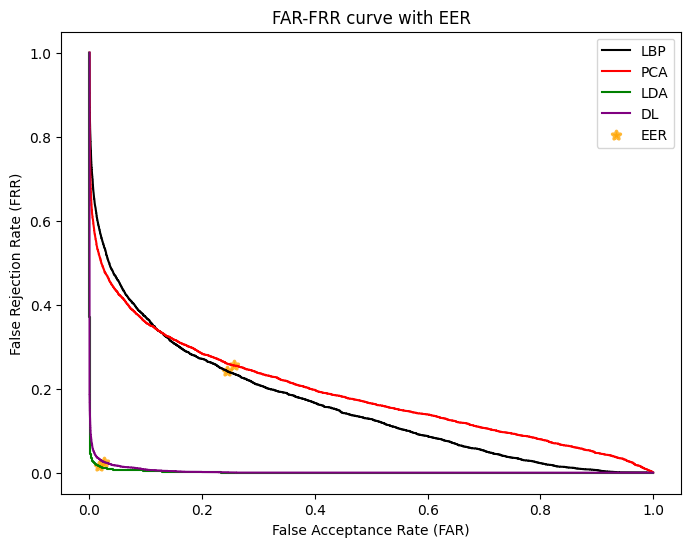

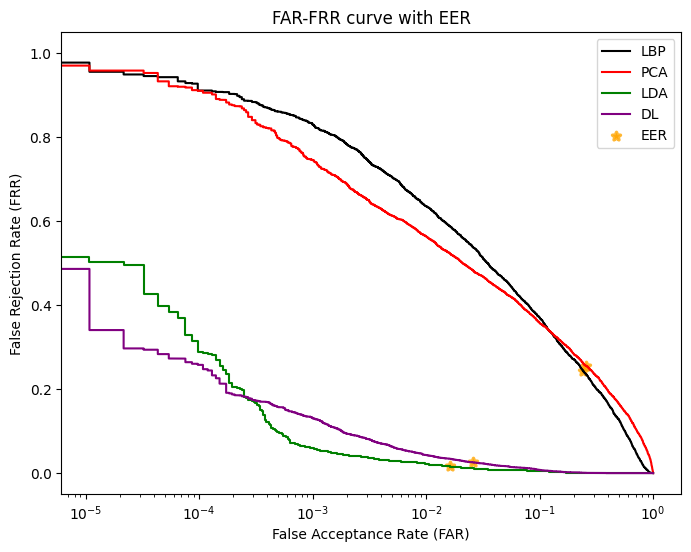

In [ ]:
def find_eer(genuine_id, scores):
    """Calculate (by approximation) the EER."""
    # Calculate FAR and FRR over different thresholds
    fpr, tpr, thresholds = roc_curve(genuine_id, scores)

    far = fpr
    frr = 1 - tpr

    # Calculate the absolute difference between FAR and FRR for each threshold
    difference = np.abs(far - frr)

    # The index where the difference is minimum is (by approximation) the EER point
    eer_index = np.argmin(difference)
    eer_decision_threshold = thresholds[eer_index]
    eer_value = fpr[eer_index]  # Since FAR == FRR at EER

    # Calculate the decision threshold for which the sum of FRR and FAR is minimal
    sum_frr_far = far + frr
    sum_frr_far_min_index = np.argmin(sum_frr_far)
    min_sum_frr_far_decision_threshold = thresholds[sum_frr_far_min_index]
    min_sum_frr_far_value = sum_frr_far[sum_frr_far_min_index]
    min_sum_frr_far_value_of_far = far[sum_frr_far_min_index]
    min_sum_frr_far_value_of_frr = frr[sum_frr_far_min_index]

    # Compute Total Classification Error (absolute misclassifications)
    total_samples = len(genuine_id)
    num_genuine = np.sum(genuine_id == 1)
    num_impostors = np.sum(genuine_id == 0)
    FP = fpr * num_impostors
    FN = (1 - tpr) * num_genuine

    total_error = FP + FN
    min_tce_index = np.argmin(total_error)  # Find threshold minimizing TCE
    min_tce_threshold = thresholds[min_tce_index]
    min_tce_value = total_error[min_tce_index] / total_samples  # Normalize TCE by total samples

    return far, frr, thresholds, eer_decision_threshold, eer_value, min_sum_frr_far_decision_threshold, min_sum_frr_far_value, min_sum_frr_far_value_of_far, min_sum_frr_far_value_of_frr, min_tce_threshold, min_tce_value

def plot_far_frr_with_eer(systems, log_scale=False):
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        far, frr, thresholds, eer_decision_threshold, eer_value, min_sum_frr_far_decision_threshold, min_sum_frr_far_value, min_sum_frr_far_value_of_far, min_sum_frr_far_value_of_frr, min_tce_threshold, min_tce_value = find_eer(genuine_id, scores)

        plt.plot(far, frr, label=f"{system_name}", color=colors[i])
        eer_marker = plt.scatter(eer_value, eer_value, color='orange', marker='*', alpha=0.8, linewidth=2.5)
        if log_scale == False:
            print(f"{system_name}:")
            print(f"  EER decision threshold: {eer_decision_threshold:.4f}")
            print(f"  EER value: {eer_value:.4f}\n")
            print(f"  The decision threshold for which the sum of FRR and FAR is minimal: {min_sum_frr_far_decision_threshold:.4f}")
            print(f"  Minimal sum of FRR and FAR: {min_sum_frr_far_value:.4f} (FRR of {min_sum_frr_far_value_of_frr:.4f} and FAR of {min_sum_frr_far_value_of_far:.4f})\n")
            print(f"  The decision threshold for which total classification error is minimal: {min_tce_threshold:.4f}")
            print(f"  Minimal total classification error: {min_tce_value:.4f}\n")

    # Add all system curves to legend first, then add EER as the last entry
    handles, labels = plt.gca().get_legend_handles_labels()
    if eer_marker is not None:
        handles.append(eer_marker)
        labels.append("EER")
    plt.legend(handles, labels)

    plt.xlabel("False Acceptance Rate (FAR)")
    plt.ylabel("False Rejection Rate (FRR)")
    plt.title("FAR-FRR curve with EER")
    if log_scale == True:
        plt.xscale("log")
    plt.show()

# Example usage (assuming `systems` is a dictionary of systems with their true labels and scores)
plot_far_frr_with_eer(systems)
plot_far_frr_with_eer(systems, log_scale=True)

PR-curve AUC for LBP is 0.4604
Average Precision for LBP is 0.4604
PR-curve AUC for PCA is 0.5176
Average Precision for PCA is 0.5176
PR-curve AUC for LDA is 0.9853
Average Precision for LDA is 0.9853
PR-curve AUC for DL is 0.9724
Average Precision for DL is 0.9724


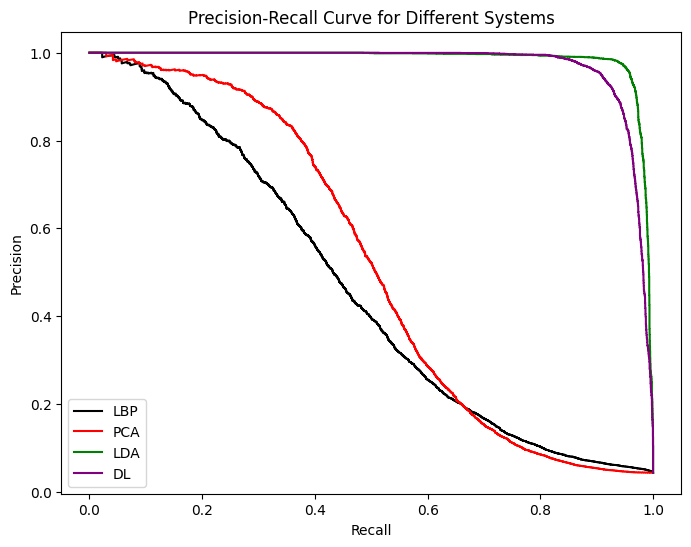

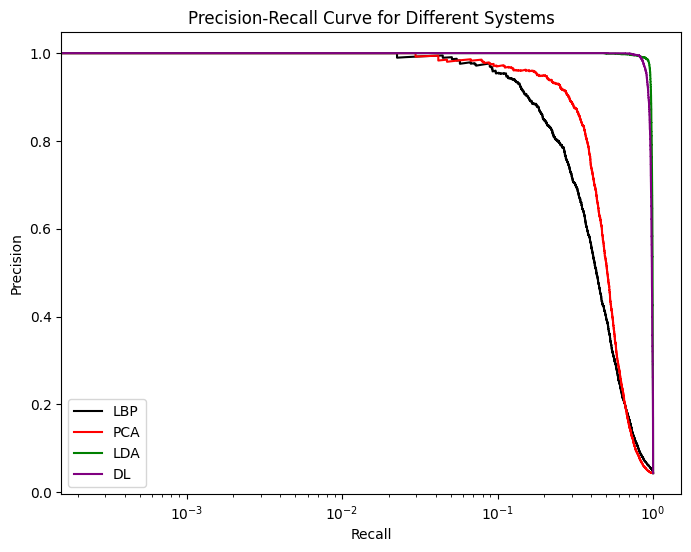

In [ ]:
def precision_recall_analysis(systems, log_scale=False):
    """Calculate and plot the Precision-Recall curve for the systems"""
    """Calculate the Area Under the PR-curve."""
    """Calculate the average precision scores"""
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        precision, recall, thresholds = precision_recall_curve(genuine_id, scores)

        # Plot the Precision-Recall curve
        plt.plot(recall, precision, label=f'{system_name}', color=colors[i])

        if log_scale == False:
            auc_score = auc(recall, precision)  # AUC for Precision-Recall curve
            print(f"PR-curve AUC for {system_name} is {auc_score:.4f}")

            ap_score = average_precision_score(genuine_id, scores)  # Compute AP
            print(f"Average Precision for {system_name} is {ap_score:.4f}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Different Systems')
    plt.legend()
    if log_scale == True:
        plt.xscale("log")
    plt.show()

precision_recall_analysis(systems)
precision_recall_analysis(systems, log_scale=True)

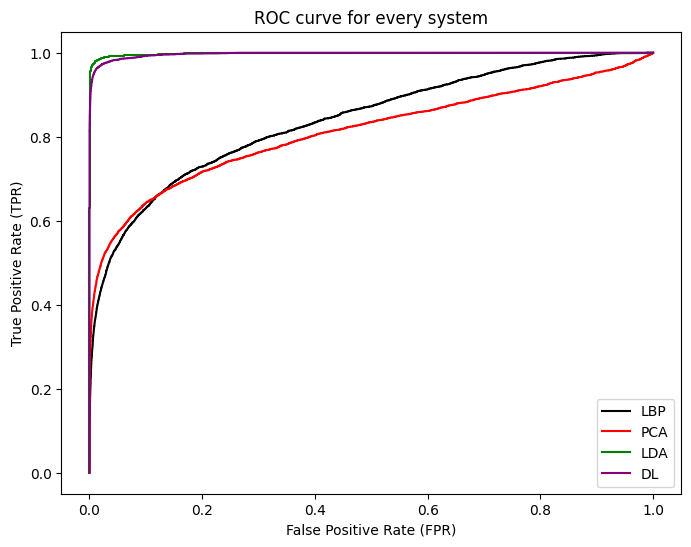

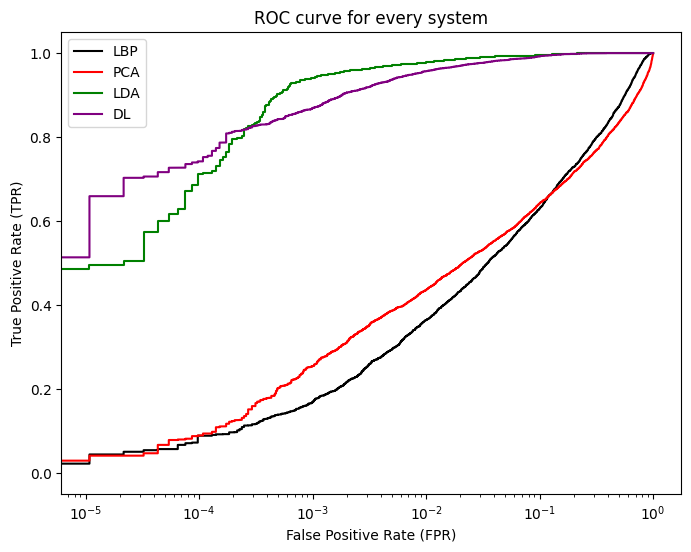

ROC AUC for LBP is 84.0122%
ROC AUC for PCA is 81.1435%
ROC AUC for LDA is 99.8497%
ROC AUC for DL is 99.7134%


In [ ]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
def plot_roc_curve(systems, log_scale=False):
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        """Calculate FPR, TPR from the matching scores."""
        fpr, tpr, _ = roc_curve(genuine_id, scores)
        plt.plot(fpr, tpr, label=f"{system_name}", color=colors[i])

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC curve for every system")
    plt.legend()
    if log_scale == True:
        plt.xscale("log")
    plt.show()
    plt.show()

plot_roc_curve(systems)
plot_roc_curve(systems, log_scale=True)

"""Calculate the ROC AUC."""
for system_name, (genuine_id, scores) in systems.items():
    auc_score = roc_auc_score(genuine_id, scores)
    print(f"ROC AUC for {system_name} is {auc_score*100:.4f}%")

### 2.2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario.
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [ ]:
from collections import defaultdict

similarity_matrices = {}
probe_labels_dict = {}
gallery_labels_dict = {}

for system_name, embedded in system_embeddings.items():
    print(f"Building CMC matrix for: {system_name}")
    dist_metric = system_metrics[system_name]
    labels = faces.target

    # Step 1: Select one probe per class, rest go to gallery
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)

    probe_indices = []
    gallery_indices = []
    for label, indices in label_to_indices.items():
        probe_indices.append(indices[0])        # First sample per class
        gallery_indices.extend(indices[1:])     # Others to gallery

    probe_emb = embedded[probe_indices]
    gallery_emb = embedded[gallery_indices]
    probe_labels = labels[probe_indices]
    gallery_labels = labels[gallery_indices]

    # Step 2: Compute full probe-to-gallery distance matrix first
    distance_matrix = np.zeros((len(probe_emb), len(gallery_emb)))
    for i in range(len(probe_emb)):
        for j in range(len(gallery_emb)):
            distance_matrix[i, j] = dist_metric(probe_emb[i], gallery_emb[j])

    # Step 3: Normalize distances globally and convert to similarity
    max_dist = np.max(distance_matrix)
    if max_dist == 0:
        similarity_matrix = np.ones_like(distance_matrix)  # all samples identical
    else:
        similarity_matrix = 1 - (distance_matrix / max_dist)

    # Step 4: Store everything
    similarity_matrices[system_name] = similarity_matrix
    probe_labels_dict[system_name] = probe_labels
    gallery_labels_dict[system_name] = gallery_labels

Building CMC matrix for: LBP
Building CMC matrix for: PCA
Building CMC matrix for: LDA
Building CMC matrix for: DL


Rank-1 Recognition Rate for LBP: 0.8077
Rank-1 Recognition Rate for PCA: 0.9231
Rank-1 Recognition Rate for LDA: 1.0000
Rank-1 Recognition Rate for DL: 1.0000


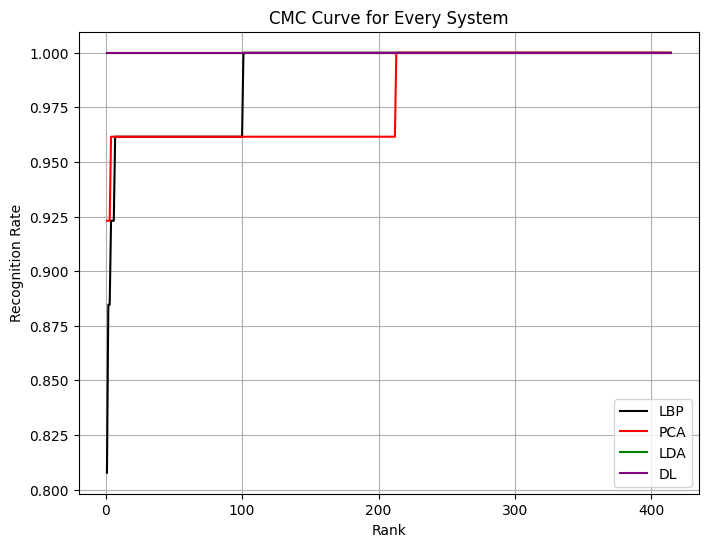

Rank-1 Recognition Rate for LBP: 0.8077
Rank-1 Recognition Rate for PCA: 0.9231
Rank-1 Recognition Rate for LDA: 1.0000
Rank-1 Recognition Rate for DL: 1.0000


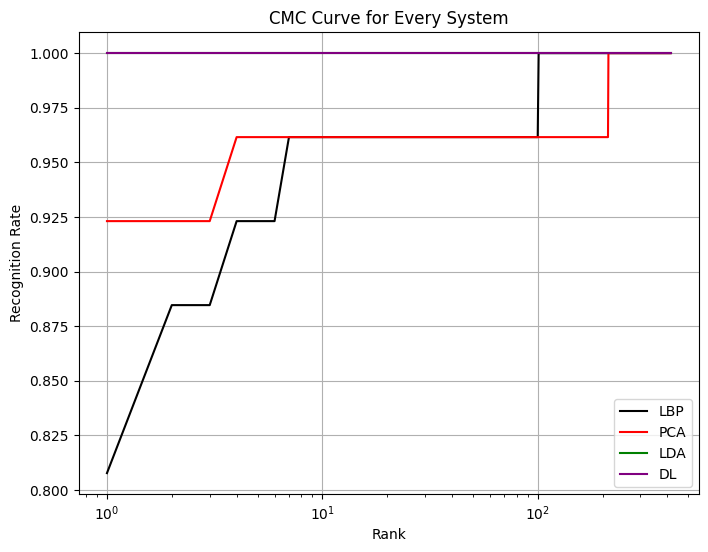

In [ ]:
def cmc_analysis(similarity_matrices, probe_labels_dict, gallery_labels_dict, log_scale=False, whether_print=1):
    """Calculate and plot the CMC curve and Rank-1 Recognition Rate for all systems."""
    plt.figure(figsize=(8, 6))

    for j, (system_name, similarity_matrix) in enumerate(similarity_matrices.items()):
        probe_labels = probe_labels_dict[system_name]
        gallery_labels = gallery_labels_dict[system_name]
        num_probes = similarity_matrix.shape[0]
        ranks = []

        for i in range(num_probes):
            sorted_indices = np.argsort(similarity_matrix[i])[::-1]
            sorted_gallery_labels = gallery_labels[sorted_indices]
            correct_label = probe_labels[i]
            rank = np.where(sorted_gallery_labels == correct_label)[0][0] + 1  # 1-based index
            ranks.append(rank)

        # CMC curve
        cmc_curve = np.array([np.sum(np.array(ranks) <= k) / num_probes for k in range(1, len(gallery_labels) + 1)])
        rank_1_recognition_rate = cmc_curve[0]

        if whether_print > 0:
            print(f"Rank-1 Recognition Rate for {system_name}: {rank_1_recognition_rate:.4f}")
        plt.plot(range(1, len(cmc_curve) + 1), cmc_curve, label=f"{system_name}", color=colors[j])

    plt.xlabel("Rank")
    plt.ylabel("Recognition Rate")
    plt.title("CMC Curve for Every System")
    plt.legend()
    plt.grid(True)
    if log_scale:
        plt.xscale("log")
    plt.show()
cmc_analysis(similarity_matrices, probe_labels_dict, gallery_labels_dict)
cmc_analysis(similarity_matrices, probe_labels_dict, gallery_labels_dict, log_scale=True)

<div class="alert alert-block alert-success">
<b>Q6: </b> Fine-tune your model for feature extraction
</div>

Hint: Tuning is the process of selecting the optimal values for a machine learning model's hyperparameters. For PCA, LDA and DL using Siamese Networks, assess the dimension of latent representations (num_components). For LBP, examine the radius. You can use default values for other parameters as provided. In your report, please explain the effect of these hyperparameters on model performance using 2 implemented evaluation metrics of your choice from Questions 3-5, and provide reasoning for their impact.

In [ ]:
radius_range = [1, 2, 3, 4, 5]
results_lbp = []

for radius in radius_range:
    print(f"Testing LBP with radius of {radius}")

    # 1. Feature extraction
    desc = LBP(numPoints=8, radius=radius, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])

    dist_metric = CHI2

    # 2. Compute distance matrix
    n_samples = embedded.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples)):
        for j in range(i, n_samples):
            d = dist_metric(embedded[i], embedded[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    # 3. Convert to similarity scores
    max_dist = np.max(distance_matrix)
    scores, true_labels = [], []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            is_genuine = int(faces.target[i] == faces.target[j])
            sim = 1 - (distance_matrix[i, j] / max_dist)
            scores.append(sim)
            true_labels.append(is_genuine)

    scores = np.array(scores)
    true_labels = np.array(true_labels)

    # 4. Evaluate
    auc_score = roc_auc_score(true_labels, scores)
    ap_score = average_precision_score(true_labels, scores)

    print(f"LBP {radius}: AUC = {auc_score:.4f}, average precision = {ap_score:.4f}")
    results_lbp.append((radius, auc_score, ap_score))


Testing LBP with radius of 1


100%|██████████| 440/440 [00:01<00:00, 344.18it/s]


LBP 1: AUC = 0.8401, average precision = 0.4604
Testing LBP with radius of 2


100%|██████████| 440/440 [00:01<00:00, 335.95it/s]


LBP 2: AUC = 0.9050, average precision = 0.7198
Testing LBP with radius of 3


100%|██████████| 440/440 [00:02<00:00, 218.67it/s]


LBP 3: AUC = 0.9114, average precision = 0.7600
Testing LBP with radius of 4


100%|██████████| 440/440 [00:01<00:00, 340.23it/s]


LBP 4: AUC = 0.9022, average precision = 0.7468
Testing LBP with radius of 5


100%|██████████| 440/440 [00:01<00:00, 342.56it/s]


LBP 5: AUC = 0.8914, average precision = 0.7214


In [ ]:
components_range = [10, 15, 20, 30, 40, 50, 100]
results_lda = []

for num_components in components_range:
    print(f"Testing LDA with {num_components} components")

    # 1. Feature extraction
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda

    dist_metric = euclidean

    # 2. Compute distance matrix
    n_samples = embedded.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples)):
        for j in range(i, n_samples):
            d = dist_metric(embedded[i], embedded[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    # 3. Convert to similarity scores
    max_dist = np.max(distance_matrix)
    scores, true_labels = [], []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            is_genuine = int(faces.target[i] == faces.target[j])
            sim = 1 - (distance_matrix[i, j] / max_dist)
            scores.append(sim)
            true_labels.append(is_genuine)

    scores = np.array(scores)
    true_labels = np.array(true_labels)

    # 4. Evaluate
    auc_score = roc_auc_score(true_labels, scores)
    ap_score = average_precision_score(true_labels, scores)

    print(f"LDA {radius}: AUC = {auc_score:.4f}, average precision = {ap_score:.4f}")
    results_lda.append((radius, auc_score, ap_score))


Testing LDA with 10 components


100%|██████████| 440/440 [00:00<00:00, 610.12it/s]


LDA 5: AUC = 0.9948, average precision = 0.9506
Testing LDA with 15 components


100%|██████████| 440/440 [00:00<00:00, 596.50it/s]


LDA 5: AUC = 0.9970, average precision = 0.9734
Testing LDA with 20 components


100%|██████████| 440/440 [00:00<00:00, 597.82it/s]


LDA 5: AUC = 0.9982, average precision = 0.9844
Testing LDA with 30 components


100%|██████████| 440/440 [00:01<00:00, 375.11it/s]


LDA 5: AUC = 0.9985, average precision = 0.9853
Testing LDA with 40 components


100%|██████████| 440/440 [00:00<00:00, 644.68it/s]


LDA 5: AUC = 0.9985, average precision = 0.9853
Testing LDA with 50 components


100%|██████████| 440/440 [00:00<00:00, 610.19it/s]


LDA 5: AUC = 0.9985, average precision = 0.9853
Testing LDA with 100 components


100%|██████████| 440/440 [00:00<00:00, 600.95it/s]


LDA 5: AUC = 0.9985, average precision = 0.9853


In [ ]:
components_range = [10, 20, 30, 40, 50, 100]
results_pca = []

for num_components in components_range:
    print(f"Testing PCA with {num_components} components")

    # 1. Feature extraction
    pca = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    embedded = pca.transform(faces.data)
    dist_metric = euclidean

    # 2. Compute distance matrix
    n_samples = embedded.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples)):
        for j in range(i, n_samples):
            d = dist_metric(embedded[i], embedded[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    # 3. Convert to similarity scores
    max_dist = np.max(distance_matrix)
    scores, true_labels = [], []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            is_genuine = int(faces.target[i] == faces.target[j])
            sim = 1 - (distance_matrix[i, j] / max_dist)
            scores.append(sim)
            true_labels.append(is_genuine)

    scores = np.array(scores)
    true_labels = np.array(true_labels)

    # 4. Evaluate
    auc_score = roc_auc_score(true_labels, scores)
    ap_score = average_precision_score(true_labels, scores)

    print(f"PCA {radius}: AUC = {auc_score:.4f}, average precision = {ap_score:.4f}")
    results_pca.append((radius, auc_score, ap_score))


Testing PCA with 10 components


100%|██████████| 440/440 [00:00<00:00, 608.09it/s]


PCA 5: AUC = 0.8253, average precision = 0.3817
Testing PCA with 20 components


100%|██████████| 440/440 [00:00<00:00, 578.60it/s]


PCA 5: AUC = 0.8609, average precision = 0.5717
Testing PCA with 30 components


100%|██████████| 440/440 [00:00<00:00, 475.62it/s]


PCA 5: AUC = 0.8340, average precision = 0.5411
Testing PCA with 40 components


100%|██████████| 440/440 [00:00<00:00, 478.00it/s]


PCA 5: AUC = 0.7896, average precision = 0.4773
Testing PCA with 50 components


100%|██████████| 440/440 [00:00<00:00, 617.55it/s]


PCA 5: AUC = 0.7545, average precision = 0.4319
Testing PCA with 100 components


100%|██████████| 440/440 [00:00<00:00, 614.59it/s]


PCA 5: AUC = 0.6451, average precision = 0.2409


In [ ]:
components_range = [10, 20, 30, 40, 50, 100]
results_dl = []

for num_components in components_range:
    print(f"Testing DL using Siamese Networks with {num_components} components")

    # 1. Feature extraction
    encoder, model = siamese.create_siamese_model(imshape, num_components)
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss,
        optimizer=rms,
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train,
              validation_split=0.2,
              batch_size=32, verbose=0, epochs=epochs)

    wfile = f"siamese_{num_components}.weights.h5"
    model.save_weights(wfile)

    embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = euclidean

    # 2. Compute distance matrix
    n_samples = embedded.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples)):
        for j in range(i, n_samples):
            d = dist_metric(embedded[i], embedded[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    # 3. Convert to similarity scores
    max_dist = np.max(distance_matrix)
    scores, true_labels = [], []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            is_genuine = int(faces.target[i] == faces.target[j])
            sim = 1 - (distance_matrix[i, j] / max_dist)
            scores.append(sim)
            true_labels.append(is_genuine)

    scores = np.array(scores)
    true_labels = np.array(true_labels)

    # 4. Evaluate
    auc_score = roc_auc_score(true_labels, scores)
    ap_score = average_precision_score(true_labels, scores)

    print(f"DL using Siamese Networks using {num_components}: AUC = {auc_score:.4f}, average precision = {ap_score:.4f}")
    results_dl.append((num_components, auc_score, ap_score))


Testing DL using Siamese Networks with 10 components


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 440/440 [00:01<00:00, 325.64it/s]


DL using Siamese Networks using 5: AUC = 0.9719, average precision = 0.6780
Testing DL using Siamese Networks with 20 components


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 440/440 [00:00<00:00, 668.00it/s]


DL using Siamese Networks using 5: AUC = 0.9881, average precision = 0.8662
Testing DL using Siamese Networks with 30 components


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 440/440 [00:00<00:00, 642.96it/s]


DL using Siamese Networks using 5: AUC = 0.9924, average precision = 0.9393
Testing DL using Siamese Networks with 40 components


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 440/440 [00:00<00:00, 677.30it/s]


DL using Siamese Networks using 5: AUC = 0.9914, average precision = 0.9164
Testing DL using Siamese Networks with 50 components


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 440/440 [00:01<00:00, 352.74it/s]


DL using Siamese Networks using 5: AUC = 0.9940, average precision = 0.9396
Testing DL using Siamese Networks with 100 components


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 440/440 [00:00<00:00, 572.49it/s]


DL using Siamese Networks using 5: AUC = 0.9924, average precision = 0.9470


In [ ]:
components_range = [10, 20, 30, 40, 50, 100]   # desired first column
results_dl_fixed = [
    (dim, old[1], old[2])                      # keep AUC & AP, swap dim
    for dim, old in zip(components_range, results_dl)
]
results_dl_fixed

[(10, np.float64(0.9719318117238401), np.float64(0.6779729512559495)),
 (20, np.float64(0.9881349110530124), np.float64(0.8662190844509792)),
 (30, np.float64(0.9923863710878768), np.float64(0.9393023296442765)),
 (40, np.float64(0.9913698432694907), np.float64(0.9163716431843979)),
 (50, np.float64(0.9939880944574605), np.float64(0.9396009344446001)),
 (100, np.float64(0.9923781384224398), np.float64(0.9469730409396628))]

<div class="alert alert-block alert-success">
<b>Q7: </b> Compare the 4 feature extraction models (LBP, PCA, LDA, DL using Siamese Networks)
</div>

Hint: Report on the performance using the implemented evaluation metrics from Questions 2-5. Perform the comparison among models under optimal hyperparameter settings as determined in Question 6

In [ ]:
num_components_dl = 35
wfile = f"siamese.weights.h5"
encoder_siamese_best, model_siamese_best = siamese.create_siamese_model(imshape, num_components_dl)
model_siamese_best.load_weights(wfile)
encoder_siamese_best = model_siamese_best.get_layer(index=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
system_embeddings_best = {}
system_metrics_best = {}

def CHI2(histA, histB, eps=1e-10):
    return 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

num_components_PCA = 20
num_components_LDA = 30
radius = 3

for desc_type in [FeatureDescriptor.LBP, FeatureDescriptor.PCA, FeatureDescriptor.LDA, FeatureDescriptor.DL]:
    print(f"Processing: {desc_type.name}")

    if desc_type == FeatureDescriptor.PCA:
        num_components = min(num_components_PCA, min(n_samples, n_features))
        print("num_components {n}".format(n=num_components))
        desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
        X_pca = desc.transform(faces.data)
        embedded = X_pca

        dist_metric = euclidean

    elif desc_type == FeatureDescriptor.LDA:
        num_components = min(num_components_LDA, min(n_classes - 1, n_features))
        desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
        X_lda = desc.fit_transform(faces.data, faces.target)
        embedded = X_lda

        dist_metric = euclidean

    elif desc_type == FeatureDescriptor.LBP:
        desc = LBP(numPoints=8, radius=radius, grid_x=7, grid_y=7)
        embedded = desc.describe_list(faces.images[...,0])

        dist_metric = CHI2

    elif desc_type == FeatureDescriptor.DL:
        embedded = encoder_siamese_best(faces.images.astype(np.float32)).numpy()
        dist_metric = euclidean

    system_embeddings_best[desc_type.name] = embedded
    system_metrics_best[desc_type.name] = dist_metric

Processing: LBP
Processing: PCA
num_components 20
Processing: LDA
Processing: DL


In [ ]:
labels = faces.target
n_samples = len(labels)

# Storage for similarity scores and ground truth labels
system_scores_best = {}
system_labels = {}

for system_name, embedded in system_embeddings_best.items():
    print(f"Processing: {system_name}")
    dist_metric = system_metrics_best[system_name]

    # Compute distance matrix
    distance_matrix = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples)):
        for j in range(i, n_samples):
            d = dist_metric(embedded[i], embedded[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d  # Symmetric

    # Normalize distances to similarity scores
    max_dist = np.max(distance_matrix)
    scores, true_labels = [], []

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            is_genuine = int(labels[i] == labels[j])
            similarity = 1 - (distance_matrix[i, j] / max_dist)

            scores.append(similarity)
            true_labels.append(is_genuine)

    # Store results
    system_scores_best[system_name] = np.array(scores)
    system_labels[system_name] = np.array(true_labels)

Processing: LBP


100%|██████████| 440/440 [00:01<00:00, 228.75it/s]


Processing: PCA


100%|██████████| 440/440 [00:01<00:00, 389.63it/s]


Processing: LDA


100%|██████████| 440/440 [00:00<00:00, 670.03it/s]


Processing: DL


100%|██████████| 440/440 [00:00<00:00, 696.19it/s]


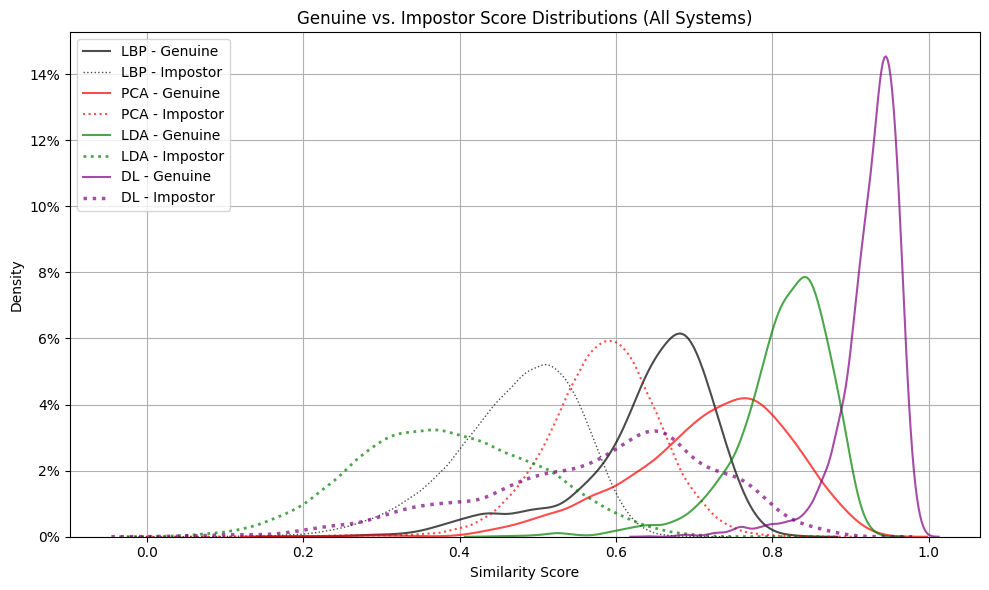

In [ ]:
# system dictionary
systems_best = {
    name: (system_labels[name], system_scores_best[name])
    for name in system_scores_best
}

colors = ['black', 'red', 'green', 'purple']  # 1 per system

plt.figure(figsize=(10, 6))

for i, (system_name, (genuine_id, scores)) in enumerate(systems_best.items()):
    # Separate genuine and impostor scores
    genuine_scores = scores[genuine_id == 1]
    impostor_scores = scores[genuine_id == 0]

    # Plot KDE curves for each system
    sns.kdeplot(genuine_scores, label=f"{system_name} - Genuine", color=colors[i],
                linestyle='-', alpha=0.7)
    sns.kdeplot(impostor_scores, label=f"{system_name} - Impostor", color=colors[i],
                linestyle=':', alpha=0.7, linewidth=1 + i / 2)

# Format y-axis as percentage
def percent(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent))

plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.title("Genuine vs. Impostor Score Distributions (All Systems)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

LBP:
  Max F1-score: 0.7367 at threshold 0.6327 with accuracy of 0.9799
  Max Accuracy: 0.9799 at threshold 0.6327 with F1-score of 0.7367

PCA:
  Max F1-score: 0.5619 at threshold 0.7347 with accuracy of 0.9663
  Max Accuracy: 0.9693 at threshold 0.7551 with F1-score of 0.5392

LDA:
  Max F1-score: 0.9581 at threshold 0.7143 with accuracy of 0.9964
  Max Accuracy: 0.9964 at threshold 0.7143 with F1-score of 0.9581

DL:
  Max F1-score: 0.9288 at threshold 0.8776 with accuracy of 0.9939
  Max Accuracy: 0.9939 at threshold 0.8776 with F1-score of 0.9288



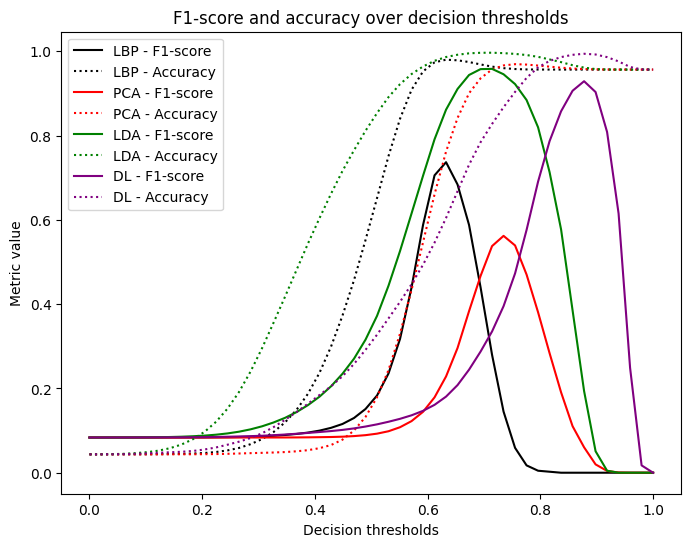

In [ ]:
thresholds = np.linspace(0, 1, 50)  # 50 threshold values between 0 and 1
plot_f1_accuracy(systems_best, thresholds)

LBP:
  EER decision threshold: 0.5539
  EER value: 0.1490

  The decision threshold for which the sum of FRR and FAR is minimal: 0.5866
  Minimal sum of FRR and FAR: 0.2549 (FRR of 0.2052 and FAR of 0.0497)

  The decision threshold for which total classification error is minimal: 0.6356
  Minimal total classification error: 0.0199

PCA:
  EER decision threshold: 0.6404
  EER value: 0.2061

  The decision threshold for which the sum of FRR and FAR is minimal: 0.6685
  Minimal sum of FRR and FAR: 0.3786 (FRR of 0.2739 and FAR of 0.1047)

  The decision threshold for which total classification error is minimal: 0.7566
  Minimal total classification error: 0.0306

LDA:
  EER decision threshold: 0.6258
  EER value: 0.0162

  The decision threshold for which the sum of FRR and FAR is minimal: 0.6413
  Minimal sum of FRR and FAR: 0.0309 (FRR of 0.0202 and FAR of 0.0107)

  The decision threshold for which total classification error is minimal: 0.7055
  Minimal total classification error: 0.0

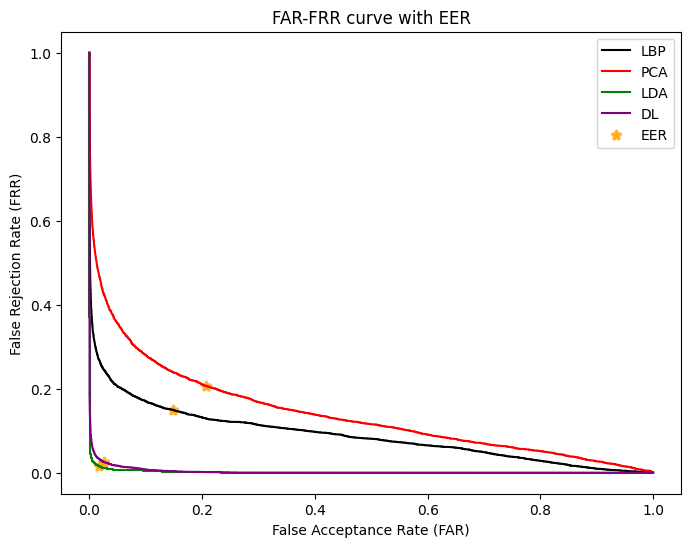

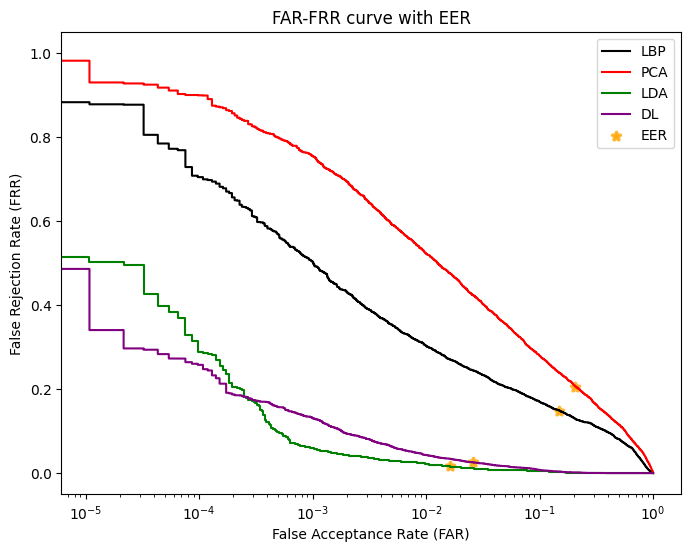

PR-curve AUC for LBP is 0.7600
Average Precision for LBP is 0.7600
PR-curve AUC for PCA is 0.5713
Average Precision for PCA is 0.5713
PR-curve AUC for LDA is 0.9853
Average Precision for LDA is 0.9853
PR-curve AUC for DL is 0.9724
Average Precision for DL is 0.9724


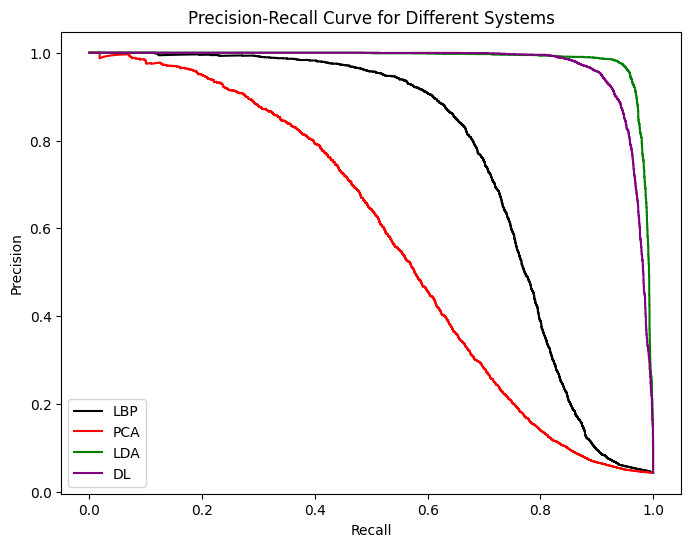

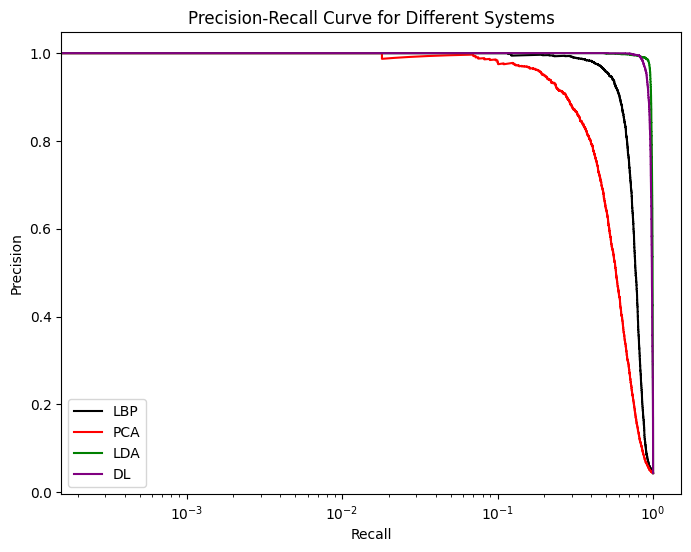

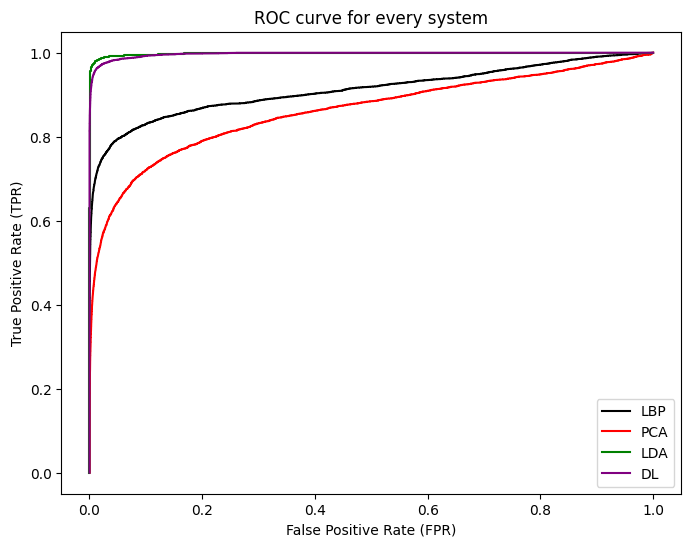

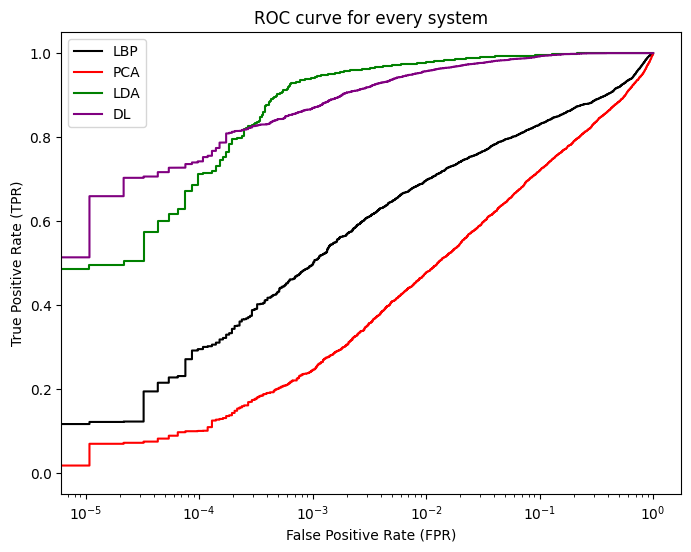

ROC AUC for LBP is 91.1406%
ROC AUC for PCA is 86.0737%
ROC AUC for LDA is 99.8497%
ROC AUC for DL is 99.7134%


In [ ]:
plot_far_frr_with_eer(systems_best)
plot_far_frr_with_eer(systems_best, log_scale=True)
precision_recall_analysis(systems_best)
precision_recall_analysis(systems_best, log_scale=True)
plot_roc_curve(systems_best)
plot_roc_curve(systems_best, log_scale=True)

"""Calculate the ROC AUC."""
for system_name, (genuine_id, scores) in systems_best.items():
    auc_score = roc_auc_score(genuine_id, scores)
    print(f"ROC AUC for {system_name} is {auc_score*100:.4f}%")

In [ ]:
similarity_matrices_best = {}
probe_labels_dict = {}
gallery_labels_dict = {}

for system_name, embedded in system_embeddings_best.items():
    print(f"Building CMC matrix for: {system_name}")
    dist_metric = system_metrics[system_name]
    labels = faces.target

    # Step 1: Select one probe per class, rest go to gallery
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)

    probe_indices = []
    gallery_indices = []
    for label, indices in label_to_indices.items():
        probe_indices.append(indices[0])        # First sample per class
        gallery_indices.extend(indices[1:])     # Others to gallery

    probe_emb = embedded[probe_indices]
    gallery_emb = embedded[gallery_indices]
    probe_labels = labels[probe_indices]
    gallery_labels = labels[gallery_indices]

    # Step 2: Compute full probe-to-gallery distance matrix first
    distance_matrix = np.zeros((len(probe_emb), len(gallery_emb)))
    for i in range(len(probe_emb)):
        for j in range(len(gallery_emb)):
            distance_matrix[i, j] = dist_metric(probe_emb[i], gallery_emb[j])

    # Step 3: Normalize distances globally and convert to similarity
    max_dist = np.max(distance_matrix)
    if max_dist == 0:
        similarity_matrix = np.ones_like(distance_matrix)  # all samples identical
    else:
        similarity_matrix = 1 - (distance_matrix / max_dist)

    # Step 4: Store everything
    similarity_matrices_best[system_name] = similarity_matrix
    probe_labels_dict[system_name] = probe_labels
    gallery_labels_dict[system_name] = gallery_labels

Building CMC matrix for: LBP
Building CMC matrix for: PCA
Building CMC matrix for: LDA
Building CMC matrix for: DL


Rank-1 Recognition Rate for LBP: 0.9615
Rank-1 Recognition Rate for PCA: 0.8846
Rank-1 Recognition Rate for LDA: 1.0000
Rank-1 Recognition Rate for DL: 1.0000


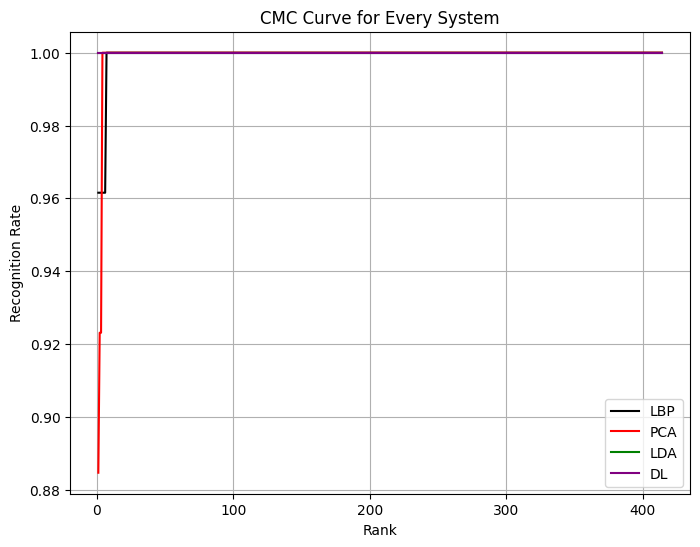

Rank-1 Recognition Rate for LBP: 0.9615
Rank-1 Recognition Rate for PCA: 0.8846
Rank-1 Recognition Rate for LDA: 1.0000
Rank-1 Recognition Rate for DL: 1.0000


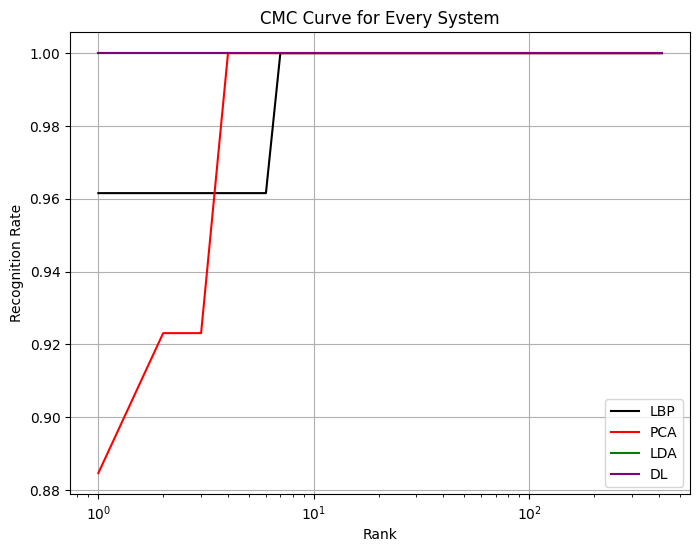

In [ ]:
cmc_analysis(similarity_matrices_best, probe_labels_dict, gallery_labels_dict)
cmc_analysis(similarity_matrices_best, probe_labels_dict, gallery_labels_dict, log_scale=True)

## V. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>.

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section 'Distance-based and classification-based scoring') (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.)
6. Implement a different deep learning model* (3pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3.

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

In [12]:
# data
X = faces.images.astype("float32") / 255.0

n_classes = np.unique(faces.target).size
y_cat = tf.keras.utils.to_categorical(faces.target, n_classes)

X_tr, X_val, y_tr, y_val = train_test_split(
        X, y_cat, test_size=0.20, stratify=faces.target, random_state=0)

# Arcface loss
class ArcMarginOneHot(layers.Layer):
    def __init__(self, n_classes, s=10.0, m=0.10, **kw):
        super().__init__(**kw)
        self.s, self.m = s, m
        self.cos_m = tf.constant(np.cos(m), tf.float32)
        self.sin_m = tf.constant(np.sin(m), tf.float32)
        self.n_classes = n_classes

    def build(self, input_shapes):
        emb_dim = int(input_shapes[0][-1])
        self.W = self.add_weight(
            name="W", shape=(emb_dim, self.n_classes),
            initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        x, y_onehot = inputs                       # y_onehot already one-hot
        x  = tf.nn.l2_normalize(x, axis=1)
        Wn = tf.nn.l2_normalize(self.W, axis=0)
        cosine = tf.matmul(x, Wn)
        sine   = tf.sqrt(1.0 - tf.square(cosine) + 1e-6)
        phi    = cosine * self.cos_m - sine * self.sin_m
        logits = self.s * (y_onehot * phi + (1. - y_onehot) * cosine)
        return logits

# model
def make_model(img_shape, n_classes, emb_dim=128):
    img_in   = Input(shape=img_shape,  name="image")
    label_in = Input(shape=(n_classes,), name="label")   # one-hot

    x = layers.Conv2D(32,3,activation='relu',padding='same')(img_in)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    emb = layers.Dense(emb_dim, activation=None, name="embedding")(x)
    logits = ArcMarginOneHot(n_classes)([emb, label_in])

    return models.Model([img_in, label_in], logits)

num_components=20

model_arc = make_model((47,47,1), n_classes, emb_dim=num_components)

model_arc.compile(
    optimizer=Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [13]:
model_arc.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 47, 47, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 23, 23,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 23, 23,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 11, 11,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 11, 11,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7744)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  3,965,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding (Dense)   │ (None, 20)        │     10,260 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, 26)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arc_margin_one_hot  │ (None, 26)        │        520 │ embedding[0][0],  │
│ (ArcMarginOneHot)   │                   │            │ label[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,997,084 (15.25 MB)

 Trainable params: 3,996,060 (15.24 MB)

 Non-trainable params: 1,024 (4.00 KB)

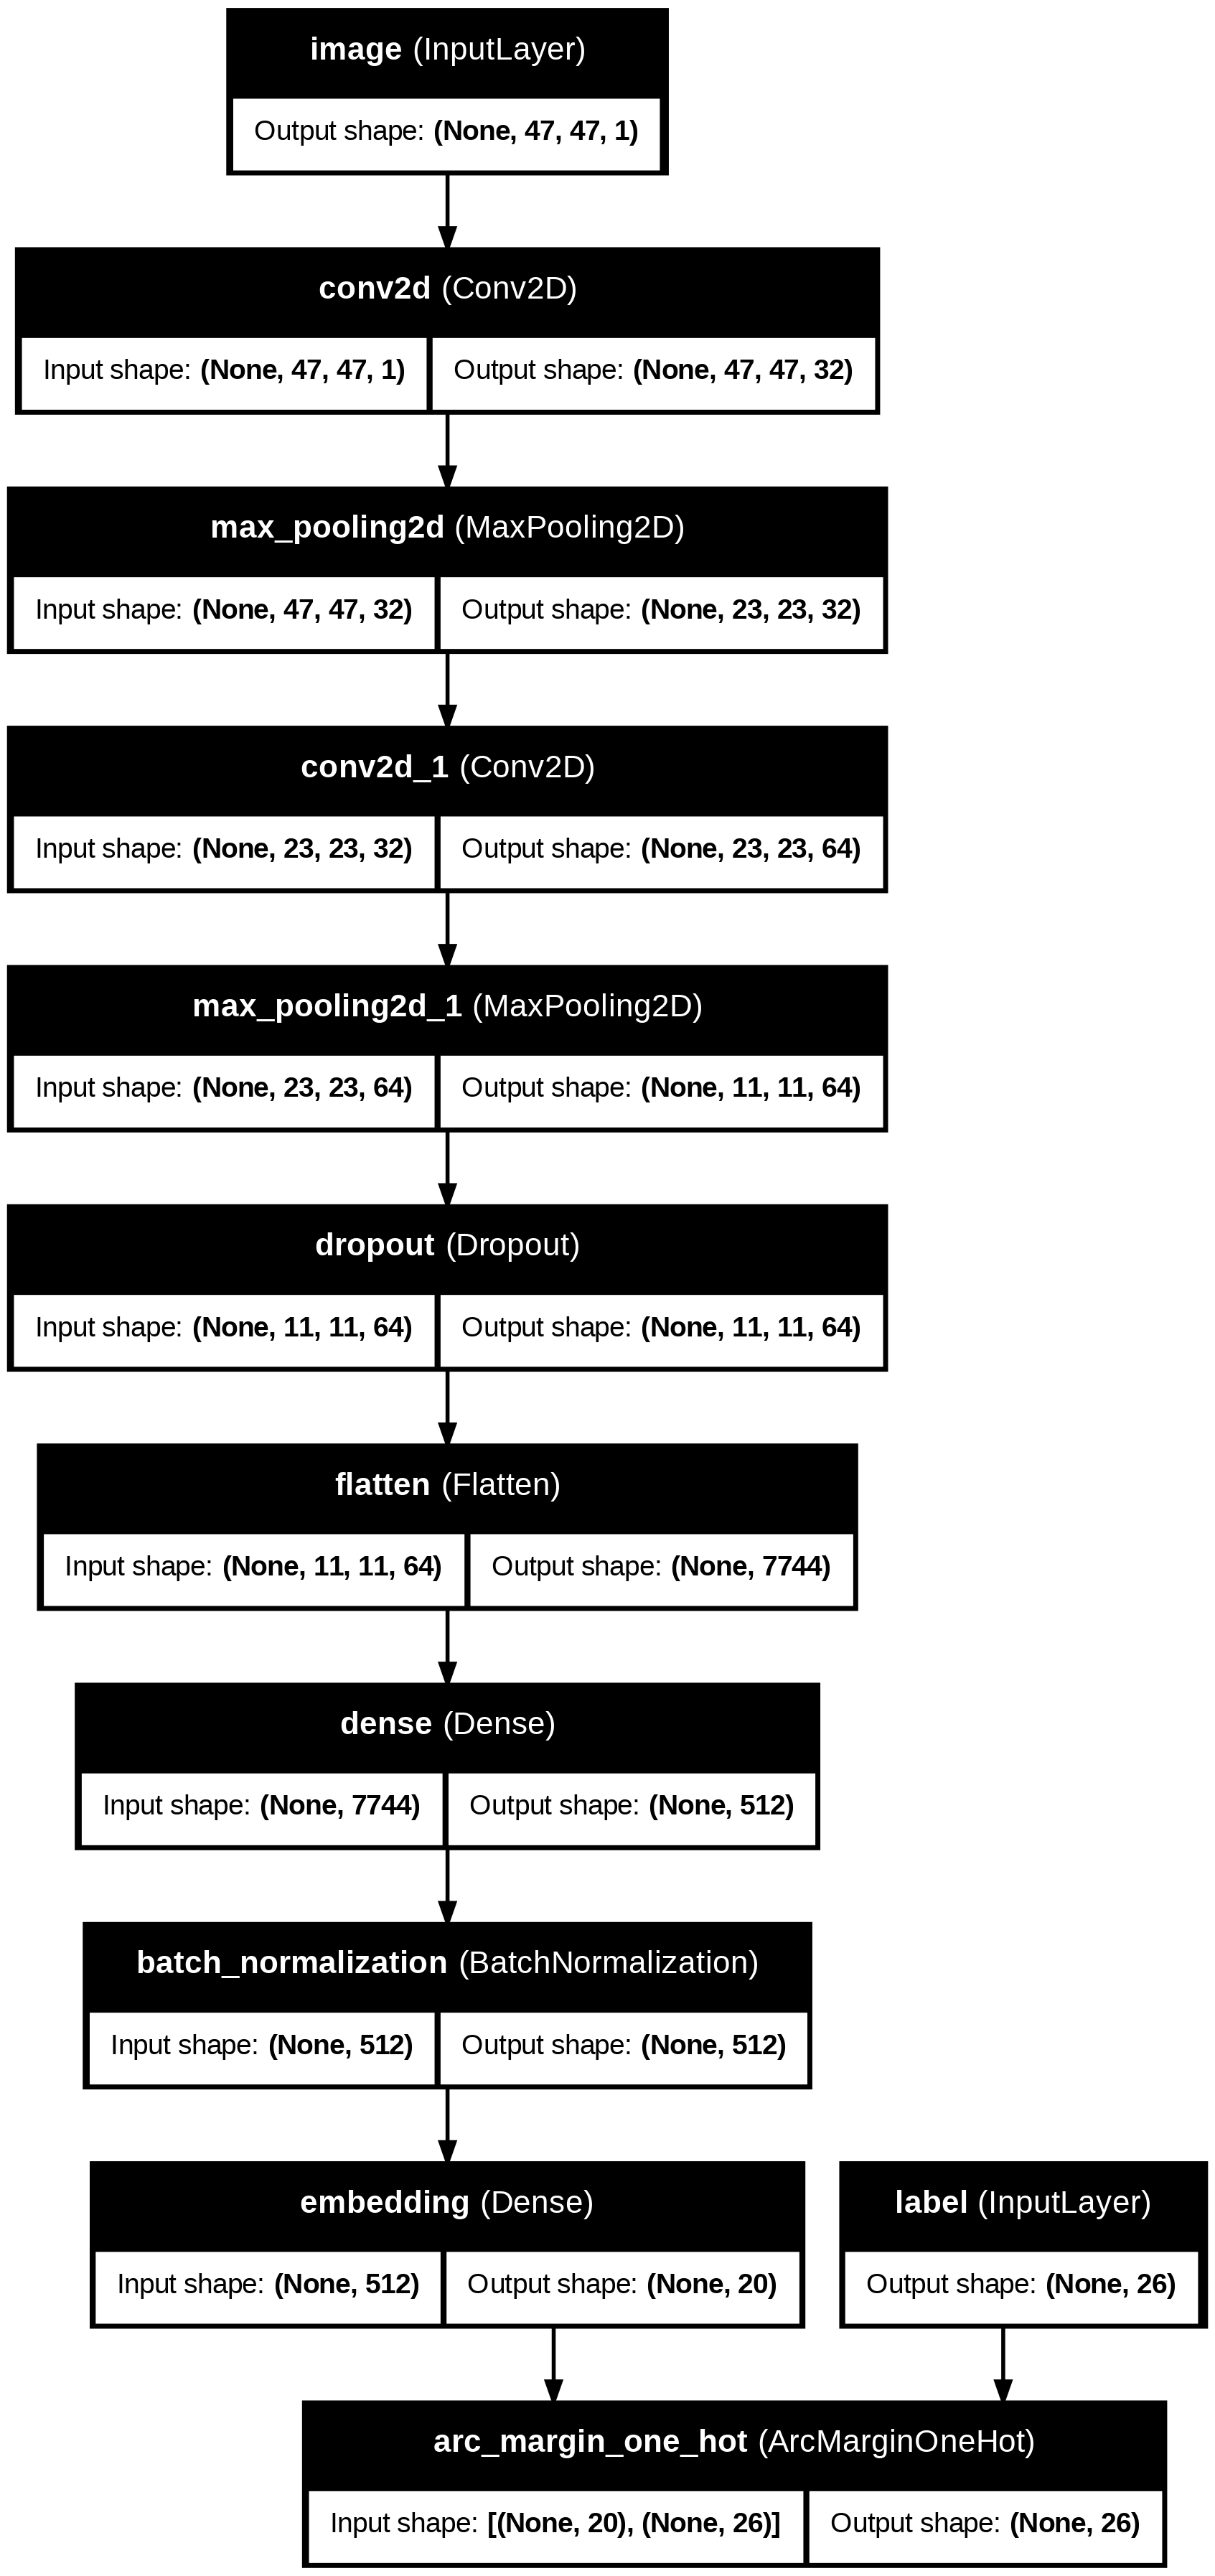

In [14]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model_arc, to_file='model_arc.png', show_shapes = True, show_layer_names = True)

In [ ]:
try:
    cnn_arc = make_model((47,47,1), n_classes=n_classes, emb_dim=num_components)
    cnn_arc.load_weights("arcface_f.weights.h5")
except:
    ckpt_cb = ModelCheckpoint(
        filepath="arcface_f.weights.h5",     # file name (SavedModel format)
        monitor="val_loss",               # or "val_sparse_categorical_accuracy"
        mode="min",                       # "min" for loss, "max" for accuracy
        save_best_only=True,              # keep only the best epoch
        save_weights_only=True           # save whole model (graph + weights)
    )

    early_cb = EarlyStopping(
        monitor="val_loss",
        patience=25
    )

    model_arc.fit([X_tr, y_tr], y_tr,
              validation_data=([X_val, y_val], y_val),
              callbacks=[ckpt_cb, early_cb],
              epochs=150, batch_size=64, verbose=2)

    cnn_arc = make_model((47,47,1), n_classes=n_classes, emb_dim=num_components)
    cnn_arc.load_weights("arcface_f.weights.h5")

Epoch 1/150
6/6 - 6s - 1s/step - accuracy: 0.1477 - loss: 4.3903 - val_accuracy: 0.0114 - val_loss: 5.5169
Epoch 2/150
6/6 - 2s - 301ms/step - accuracy: 0.6307 - loss: 1.3995 - val_accuracy: 0.0114 - val_loss: 5.1792
Epoch 3/150
6/6 - 2s - 301ms/step - accuracy: 0.8438 - loss: 0.5931 - val_accuracy: 0.1023 - val_loss: 3.8455
Epoch 4/150
6/6 - 2s - 305ms/step - accuracy: 0.9432 - loss: 0.2999 - val_accuracy: 0.3523 - val_loss: 2.8028
Epoch 5/150
6/6 - 2s - 298ms/step - accuracy: 0.9801 - loss: 0.1617 - val_accuracy: 0.7273 - val_loss: 1.0138
Epoch 6/150
6/6 - 3s - 569ms/step - accuracy: 0.9915 - loss: 0.0979 - val_accuracy: 0.7500 - val_loss: 0.9313
Epoch 7/150
6/6 - 4s - 719ms/step - accuracy: 0.9972 - loss: 0.0660 - val_accuracy: 0.8295 - val_loss: 0.7257
Epoch 8/150
6/6 - 2s - 415ms/step - accuracy: 1.0000 - loss: 0.0489 - val_accuracy: 0.8977 - val_loss: 0.5172
Epoch 9/150
6/6 - 3s - 425ms/step - accuracy: 1.0000 - loss: 0.0373 - val_accuracy: 0.9091 - val_loss: 0.5121
Epoch 10/150


In [ ]:
encoder_arc = tf.keras.Model(
    inputs=cnn_arc.input[0],                       # only the *image* branch
    outputs=cnn_arc.get_layer("embedding").output) # 32/64/128-D vector

X_all = faces.images.astype("float32") / 255.0

embedded_arc = encoder_arc.predict(X_all, batch_size=64)   # (N, emb_dim)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step


In [ ]:
dist_metric = euclidean
n_samples   = embedded_arc.shape[0]

distance_matrix = np.zeros((n_samples, n_samples), dtype=np.float32)
for i in tqdm(range(n_samples)):
    for j in range(i, n_samples):
        d = dist_metric(embedded_arc[i], embedded_arc[j])
        distance_matrix[i, j] = d
        distance_matrix[j, i] = d

max_dist = distance_matrix.max()
scores, true_labels = [], []
for i in range(n_samples):
    for j in range(i + 1, n_samples):
        is_genuine = int(faces.target[i] == faces.target[j])
        sim = 1.0 - distance_matrix[i, j] / max_dist
        scores.append(sim)
        true_labels.append(is_genuine)

scores       = np.array(scores)
true_labels  = np.array(true_labels)

# Evaluate
auc_score = roc_auc_score(true_labels, scores)
ap_score = average_precision_score(true_labels, scores)

results_dl_new = []

print(f"DL using CNN ArcFace Networks: AUC = {auc_score:.4f}, average precision = {ap_score:.4f}")
results_dl_new.append((auc_score, ap_score))

100%|██████████| 440/440 [00:00<00:00, 672.28it/s]


DL using CNN ArcFace Networks: AUC = 1.0000, average precision = 0.9996


In [ ]:
system_scores_best['DL_ARC']  = scores
system_labels['DL_ARC']  = true_labels
system_embeddings_best['DL_ARC']  = embedded_arc
system_metrics_best['DL_ARC']  = euclidean

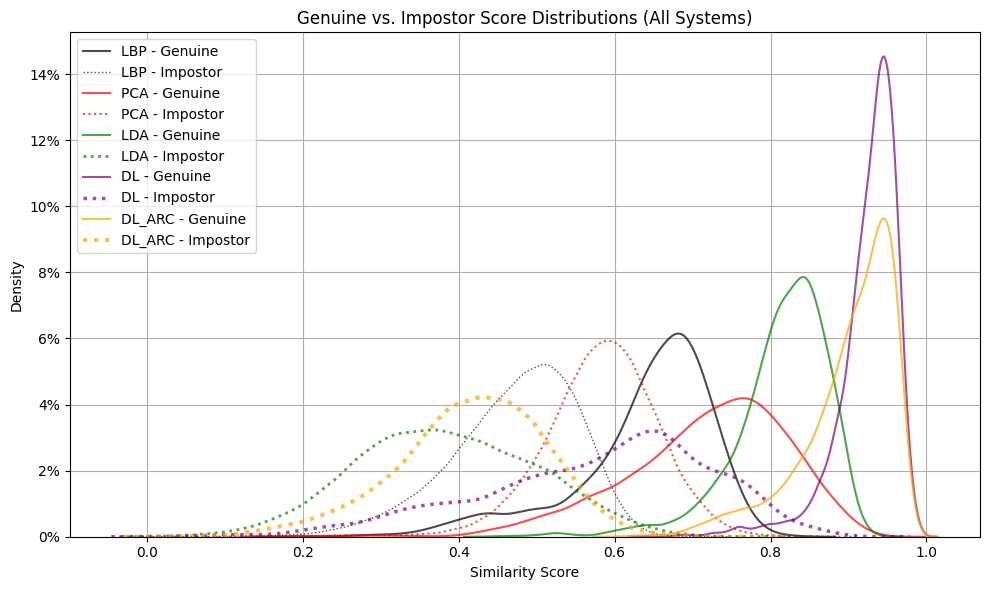

In [ ]:
# Build `systems` dictionary from your stored system results
systems_best = {
    name: (system_labels[name], system_scores_best[name])
    for name in system_scores_best
}

colors = ['black', 'red', 'green', 'purple', 'orange']  # 1 per system

plt.figure(figsize=(10, 6))

for i, (system_name, (genuine_id, scores)) in enumerate(systems_best.items()):
    # Separate genuine and impostor scores
    genuine_scores = scores[genuine_id == 1]
    impostor_scores = scores[genuine_id == 0]

    # Plot KDE curves for each system
    sns.kdeplot(genuine_scores, label=f"{system_name} - Genuine", color=colors[i],
                linestyle='-', alpha=0.7)
    sns.kdeplot(impostor_scores, label=f"{system_name} - Impostor", color=colors[i],
                linestyle=':', alpha=0.7, linewidth=1 + i / 2)

# Format y-axis as percentage
def percent(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent))

# Final touches
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.title("Genuine vs. Impostor Score Distributions (All Systems)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

LBP:
  Max F1-score: 0.7367 at threshold 0.6327 with accuracy of 0.9799
  Max Accuracy: 0.9799 at threshold 0.6327 with F1-score of 0.7367

PCA:
  Max F1-score: 0.5619 at threshold 0.7347 with accuracy of 0.9663
  Max Accuracy: 0.9693 at threshold 0.7551 with F1-score of 0.5392

LDA:
  Max F1-score: 0.9581 at threshold 0.7143 with accuracy of 0.9964
  Max Accuracy: 0.9964 at threshold 0.7143 with F1-score of 0.9581

DL:
  Max F1-score: 0.9288 at threshold 0.8776 with accuracy of 0.9939
  Max Accuracy: 0.9939 at threshold 0.8776 with F1-score of 0.9288

DL_ARC:
  Max F1-score: 0.9913 at threshold 0.7143 with accuracy of 0.9992
  Max Accuracy: 0.9992 at threshold 0.7143 with F1-score of 0.9913



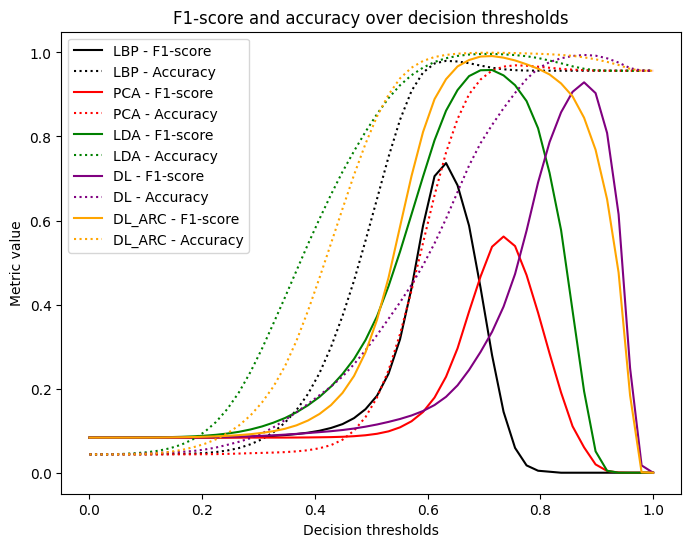

LBP:
  EER decision threshold: 0.5539
  EER value: 0.1490

  The decision threshold for which the sum of FRR and FAR is minimal: 0.5866
  Minimal sum of FRR and FAR: 0.2549 (FRR of 0.2052 and FAR of 0.0497)

  The decision threshold for which total classification error is minimal: 0.6356
  Minimal total classification error: 0.0199

PCA:
  EER decision threshold: 0.6404
  EER value: 0.2061

  The decision threshold for which the sum of FRR and FAR is minimal: 0.6685
  Minimal sum of FRR and FAR: 0.3786 (FRR of 0.2739 and FAR of 0.1047)

  The decision threshold for which total classification error is minimal: 0.7566
  Minimal total classification error: 0.0306

LDA:
  EER decision threshold: 0.6258
  EER value: 0.0162

  The decision threshold for which the sum of FRR and FAR is minimal: 0.6413
  Minimal sum of FRR and FAR: 0.0309 (FRR of 0.0202 and FAR of 0.0107)

  The decision threshold for which total classification error is minimal: 0.7055
  Minimal total classification error: 0.0

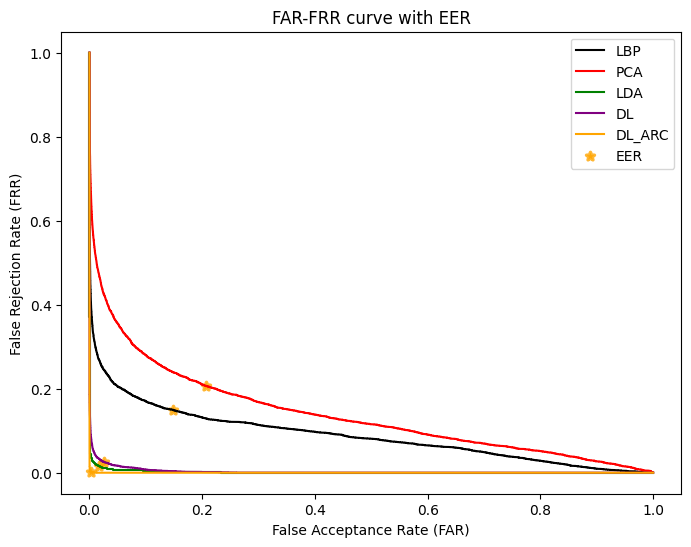

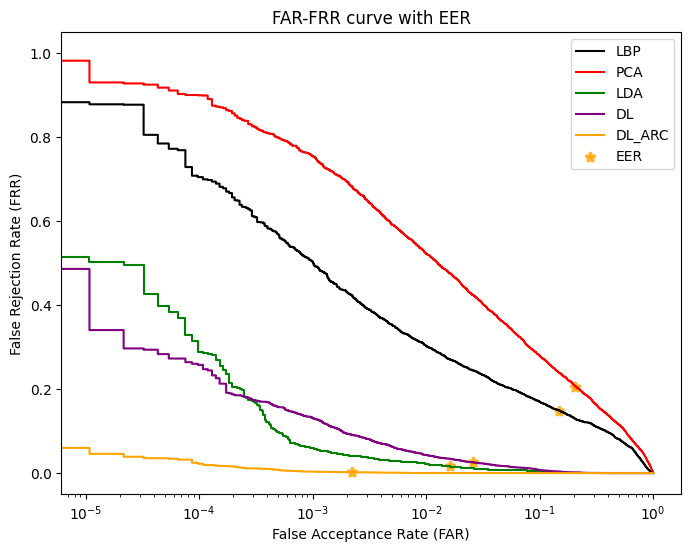

PR-curve AUC for LBP is 0.7600
Average Precision for LBP is 0.7600
PR-curve AUC for PCA is 0.5713
Average Precision for PCA is 0.5713
PR-curve AUC for LDA is 0.9853
Average Precision for LDA is 0.9853
PR-curve AUC for DL is 0.9724
Average Precision for DL is 0.9724
PR-curve AUC for DL_ARC is 0.9996
Average Precision for DL_ARC is 0.9996


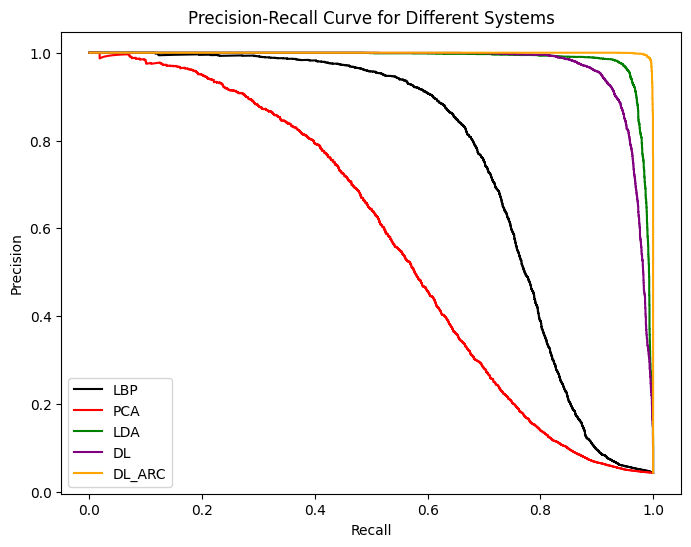

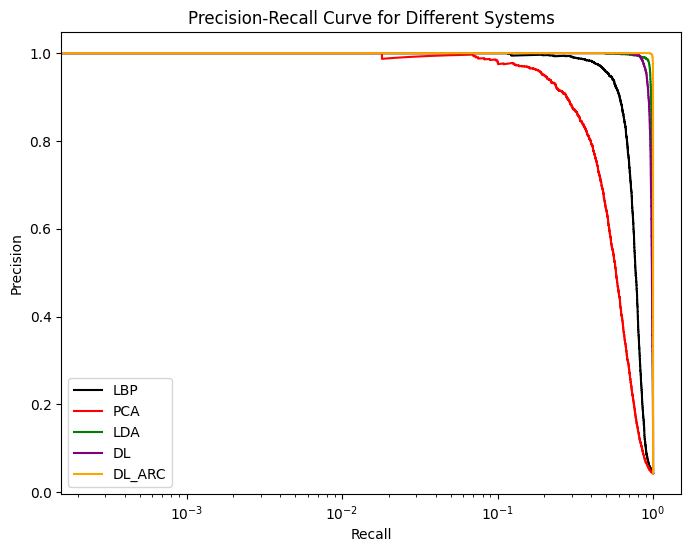

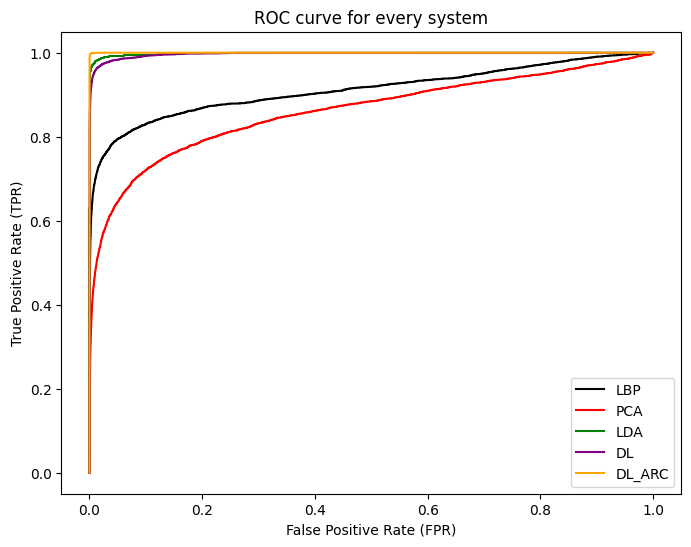

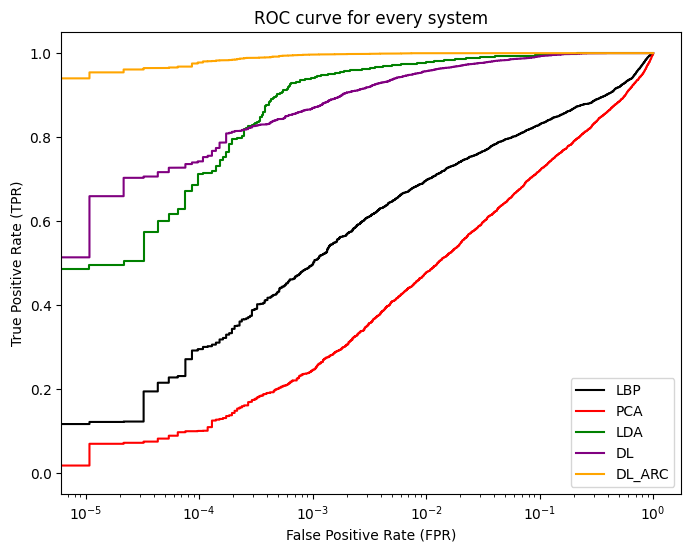

ROC AUC for LBP is 91.1406%
ROC AUC for PCA is 86.0737%
ROC AUC for LDA is 99.8497%
ROC AUC for DL is 99.7134%
ROC AUC for DL_ARC is 99.9978%


In [ ]:
thresholds = np.linspace(0, 1, 50)  # 50 threshold values between 0 and 1
plot_f1_accuracy(systems_best, thresholds)
plot_far_frr_with_eer(systems_best)
plot_far_frr_with_eer(systems_best, log_scale=True)
precision_recall_analysis(systems_best)
precision_recall_analysis(systems_best, log_scale=True)
plot_roc_curve(systems_best)
plot_roc_curve(systems_best, log_scale=True)

"""Calculate the ROC AUC."""
for system_name, (genuine_id, scores) in systems_best.items():
    auc_score = roc_auc_score(genuine_id, scores)
    print(f"ROC AUC for {system_name} is {auc_score*100:.4f}%")

In [ ]:
similarity_matrices_best = {}
probe_labels_dict = {}
gallery_labels_dict = {}

for system_name, embedded in system_embeddings_best.items():
    print(f"Building CMC matrix for: {system_name}")
    dist_metric = system_metrics_best[system_name]
    labels = faces.target

    # Step 1: Select one probe per class, rest go to gallery
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)

    probe_indices = []
    gallery_indices = []
    for label, indices in label_to_indices.items():
        probe_indices.append(indices[0])        # First sample per class
        gallery_indices.extend(indices[1:])     # Others to gallery

    probe_emb = embedded[probe_indices]
    gallery_emb = embedded[gallery_indices]
    probe_labels = labels[probe_indices]
    gallery_labels = labels[gallery_indices]

    # Step 2: Compute full probe-to-gallery distance matrix first
    distance_matrix = np.zeros((len(probe_emb), len(gallery_emb)))
    for i in range(len(probe_emb)):
        for j in range(len(gallery_emb)):
            distance_matrix[i, j] = dist_metric(probe_emb[i], gallery_emb[j])

    # Step 3: Normalize distances globally and convert to similarity
    max_dist = np.max(distance_matrix)
    if max_dist == 0:
        similarity_matrix = np.ones_like(distance_matrix)  # all samples identical
    else:
        similarity_matrix = 1 - (distance_matrix / max_dist)

    # Step 4: Store everything
    similarity_matrices_best[system_name] = similarity_matrix
    probe_labels_dict[system_name] = probe_labels
    gallery_labels_dict[system_name] = gallery_labels

Building CMC matrix for: LBP
Building CMC matrix for: PCA
Building CMC matrix for: LDA
Building CMC matrix for: DL
Building CMC matrix for: DL_ARC


Rank-1 Recognition Rate for LBP: 0.9615
Rank-1 Recognition Rate for PCA: 0.8846
Rank-1 Recognition Rate for LDA: 1.0000
Rank-1 Recognition Rate for DL: 1.0000
Rank-1 Recognition Rate for DL_ARC: 1.0000


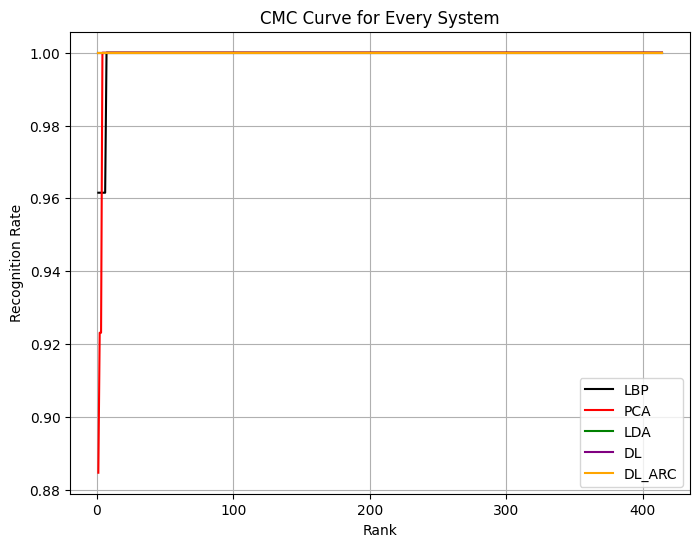

Rank-1 Recognition Rate for LBP: 0.9615
Rank-1 Recognition Rate for PCA: 0.8846
Rank-1 Recognition Rate for LDA: 1.0000
Rank-1 Recognition Rate for DL: 1.0000
Rank-1 Recognition Rate for DL_ARC: 1.0000


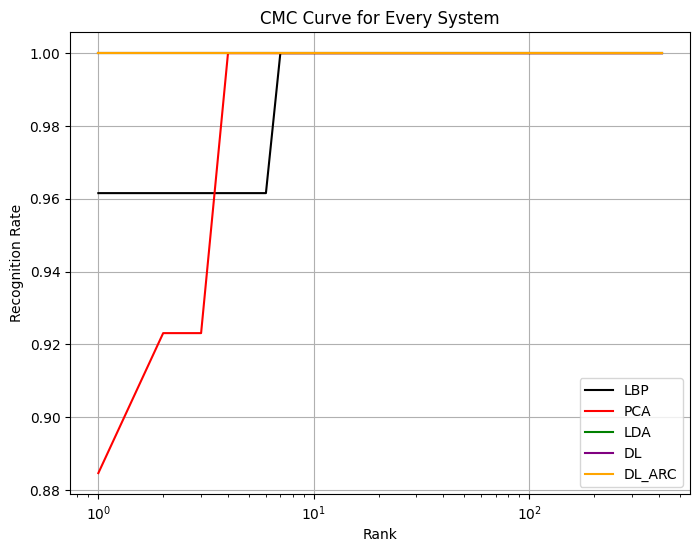

In [ ]:
cmc_analysis(similarity_matrices_best, probe_labels_dict, gallery_labels_dict)
cmc_analysis(similarity_matrices_best, probe_labels_dict, gallery_labels_dict, log_scale=True)